In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [7]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), 
            y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='relu', name=f'{name}_embeddings_1')(req_emb)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = base_model.get_layer(output_name).output
    outputs = Dropout(rate=0.5)(outputs)
    outputs = Dense(units=128, activation='relu', name=f'{name}_dense')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return file_model

# Requirements Training 

In [12]:
list_model_files = []

#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 19s 193ms/step - loss: 91.7138 - val_loss: 82.9233
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 71.6600 - val_loss: 83.9858
Epoch 3/100
100/100 [==============================] - 16s 159ms/step - loss: 54.5191 - val_loss: 74.8078
Epoch 4/100
100/100 [==============================] - 16s 158ms/step - loss: 37.6725 - val_loss: 70.8113
Epoch 5/100
100/100 [==============================] - 16s 158ms/step - loss: 24.8203 - val_loss: 82.1304
Epoch 6/100
100/100 [==============================] - 16s 158ms/step - loss: 16.2852 - val_loss: 91.6679
Epoch 7/100
100/100 [==============================] - 16s 159ms/step - loss: 10.7109 - val_loss: 99.9885
Epoch 8/100
100/100 [==============================] - 16s 159ms/step - loss: 7.1191 - val_loss: 100.6773
Epoch 9/100
100/100 [==============================] - 16s 159ms/step - loss: 5.5006 - val_loss: 105.176

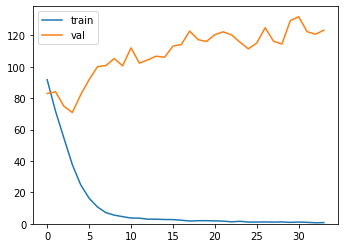

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 499ms/step - loss: 0.9555 - accuracy: 0.4375 - precision: 0.4475 - recall: 0.7480 - f1: 0.5524 - specificity: 0.1461 - negative_predictive_value: 0.3917 - matthews_correlation_coefficient: -0.1302 - equal_error_rate: 0.5630 - val_loss: 0.8007 - val_accuracy: 0.3600 - val_precision: 0.3684 - val_recall: 0.6364 - val_f1: 0.4667 - val_specificity: 0.1429 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.2566 - val_equal_error_rate: 0.5227

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.25661, saving model to ../../models/siamese_networks/blurred_2020_06_09-20_52_01.h5
Epoch 2/100
3/3 [==============================] - 1s 236ms/step - loss: 0.8635 - accuracy: 0.4875 - precision: 0.5245 - recall: 0.6621 - f1: 0.5750 - specificity: 0.3175 - negative_predictive_value: 0.4545 - matthews_correlation_coefficient: -0.0207 - equal_error_rate: 0.5370 - val_loss: 0.7876 - val_accuracy: 


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.09869
Epoch 14/100
3/3 [==============================] - 0s 153ms/step - loss: 0.7494 - accuracy: 0.4875 - precision: 0.5053 - recall: 0.5424 - f1: 0.5074 - specificity: 0.3968 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: -0.0635 - equal_error_rate: 0.5277 - val_loss: 0.6726 - val_accuracy: 0.5600 - val_precision: 0.5000 - val_recall: 0.4545 - val_f1: 0.4762 - val_specificity: 0.6429 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.0987 - val_equal_error_rate: 0.4058

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.09869
Epoch 15/100
3/3 [==============================] - 0s 153ms/step - loss: 0.6732 - accuracy: 0.6125 - precision: 0.5813 - recall: 0.5929 - f1: 0.5838 - specificity: 0.6083 - negative_predictive_value: 0.6179 - matthews_correlation_coefficient: 0.2002 - equal_error_rate: 0.4769 - val_loss: 0.6662 - val_accuracy: 

3/3 [==============================] - 0s 160ms/step - loss: 0.6561 - accuracy: 0.5875 - precision: 0.5723 - recall: 0.6121 - f1: 0.5826 - specificity: 0.5892 - negative_predictive_value: 0.6167 - matthews_correlation_coefficient: 0.1950 - equal_error_rate: 0.4079 - val_loss: 0.6091 - val_accuracy: 0.6400 - val_precision: 0.5833 - val_recall: 0.6364 - val_f1: 0.6087 - val_specificity: 0.6429 - val_negative_predictive_value: 0.6923 - val_matthews_correlation_coefficient: 0.2774 - val_equal_error_rate: 0.3604

Epoch 00027: val_matthews_correlation_coefficient improved from 0.18831 to 0.27743, saving model to ../../models/siamese_networks/blurred_2020_06_09-20_52_01.h5
Epoch 28/100
3/3 [==============================] - 0s 152ms/step - loss: 0.5273 - accuracy: 0.7750 - precision: 0.8130 - recall: 0.7333 - f1: 0.7696 - specificity: 0.7745 - negative_predictive_value: 0.6793 - matthews_correlation_coefficient: 0.4999 - equal_error_rate: 0.2461 - val_loss: 0.6054 - val_accuracy: 0.6400 - val

3/3 [==============================] - 0s 149ms/step - loss: 0.5802 - accuracy: 0.7000 - precision: 0.7745 - recall: 0.6889 - f1: 0.7266 - specificity: 0.7435 - negative_predictive_value: 0.6375 - matthews_correlation_coefficient: 0.4220 - equal_error_rate: 0.2642 - val_loss: 0.5781 - val_accuracy: 0.6400 - val_precision: 0.5833 - val_recall: 0.6364 - val_f1: 0.6087 - val_specificity: 0.6429 - val_negative_predictive_value: 0.6923 - val_matthews_correlation_coefficient: 0.2774 - val_equal_error_rate: 0.3604

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.27743
Epoch 41/100
3/3 [==============================] - 0s 159ms/step - loss: 0.5750 - accuracy: 0.6562 - precision: 0.6286 - recall: 0.7116 - f1: 0.6644 - specificity: 0.5845 - negative_predictive_value: 0.6506 - matthews_correlation_coefficient: 0.2875 - equal_error_rate: 0.3040 - val_loss: 0.5763 - val_accuracy: 0.6400 - val_precision: 0.5833 - val_recall: 0.6364 - val_f1: 0.6087 - val_specificity: 0.6429

3/3 [==============================] - 0s 150ms/step - loss: 0.4958 - accuracy: 0.7604 - precision: 0.7453 - recall: 0.7313 - f1: 0.7366 - specificity: 0.7666 - negative_predictive_value: 0.7512 - matthews_correlation_coefficient: 0.4971 - equal_error_rate: 0.2094 - val_loss: 0.5635 - val_accuracy: 0.6800 - val_precision: 0.6154 - val_recall: 0.7273 - val_f1: 0.6667 - val_specificity: 0.6429 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.3677 - val_equal_error_rate: 0.2435

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.36775
Epoch 54/100
3/3 [==============================] - 0s 146ms/step - loss: 0.5158 - accuracy: 0.8125 - precision: 0.8585 - recall: 0.8000 - f1: 0.8056 - specificity: 0.8532 - negative_predictive_value: 0.7641 - matthews_correlation_coefficient: 0.6375 - equal_error_rate: 0.2236 - val_loss: 0.5624 - val_accuracy: 0.6800 - val_precision: 0.6154 - val_recall: 0.7273 - val_f1: 0.6667 - val_specificity: 0.6429

3/3 [==============================] - 0s 149ms/step - loss: 0.5478 - accuracy: 0.7625 - precision: 0.7586 - recall: 0.6924 - f1: 0.7186 - specificity: 0.7698 - negative_predictive_value: 0.6879 - matthews_correlation_coefficient: 0.4543 - equal_error_rate: 0.2685 - val_loss: 0.5550 - val_accuracy: 0.7600 - val_precision: 0.7273 - val_recall: 0.7273 - val_f1: 0.7273 - val_specificity: 0.7857 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.5130 - val_equal_error_rate: 0.2435

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.51299
Epoch 67/100
3/3 [==============================] - 0s 153ms/step - loss: 0.4581 - accuracy: 0.7750 - precision: 0.7617 - recall: 0.7313 - f1: 0.7371 - specificity: 0.8063 - negative_predictive_value: 0.7576 - matthews_correlation_coefficient: 0.5283 - equal_error_rate: 0.2701 - val_loss: 0.5549 - val_accuracy: 0.7600 - val_precision: 0.7273 - val_recall: 0.7273 - val_f1: 0.7273 - val_specificity: 0.7857


Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.51299
Epoch 80/100
3/3 [==============================] - 0s 151ms/step - loss: 0.4217 - accuracy: 0.8625 - precision: 0.8856 - recall: 0.8611 - f1: 0.8706 - specificity: 0.8578 - negative_predictive_value: 0.8111 - matthews_correlation_coefficient: 0.7077 - equal_error_rate: 0.1418 - val_loss: 0.5536 - val_accuracy: 0.7600 - val_precision: 0.7273 - val_recall: 0.7273 - val_f1: 0.7273 - val_specificity: 0.7857 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.5130 - val_equal_error_rate: 0.2435

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.51299
Epoch 81/100
3/3 [==============================] - 0s 167ms/step - loss: 0.4203 - accuracy: 0.8229 - precision: 0.8070 - recall: 0.8283 - f1: 0.8155 - specificity: 0.8058 - negative_predictive_value: 0.8168 - matthews_correlation_coefficient: 0.6288 - equal_error_rate: 0.1898 - val_loss: 0.5534 - val_accuracy: 0

3/3 [==============================] - 1s 169ms/step - loss: 0.5180 - accuracy: 0.7500 - precision: 0.6918 - recall: 0.8146 - f1: 0.7477 - specificity: 0.6597 - negative_predictive_value: 0.7889 - matthews_correlation_coefficient: 0.4770 - equal_error_rate: 0.3154 - val_loss: 0.5528 - val_accuracy: 0.7600 - val_precision: 0.7273 - val_recall: 0.7273 - val_f1: 0.7273 - val_specificity: 0.7857 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.5130 - val_equal_error_rate: 0.2435

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.51299
Epoch 94/100
3/3 [==============================] - 0s 164ms/step - loss: 0.4047 - accuracy: 0.8500 - precision: 0.8792 - recall: 0.7894 - f1: 0.8302 - specificity: 0.8849 - negative_predictive_value: 0.7718 - matthews_correlation_coefficient: 0.6625 - equal_error_rate: 0.1458 - val_loss: 0.5525 - val_accuracy: 0.7600 - val_precision: 0.7273 - val_recall: 0.7273 - val_f1: 0.7273 - val_specificity: 0.7857

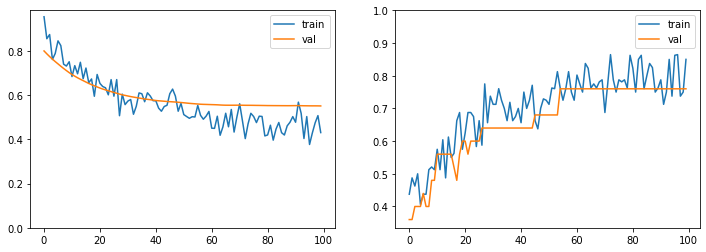

In [14]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 243ms/step - loss: 97.7206 - val_loss: 97.4003
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 93.1334 - val_loss: 91.0081
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 87.9064 - val_loss: 89.6238
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 82.6967 - val_loss: 86.1841
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 76.8012 - val_loss: 88.5602
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 71.3963 - val_loss: 87.7182
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 66.4020 - val_loss: 88.6172
Epoch 8/100
100/100 [==============================] - 23s 230ms/step - loss: 61.2965 - val_loss: 85.8102
Epoch 9/100
100/100 [==============================] - 23s 230ms/step - loss: 55.8819 - val_loss: 87.9472
Epoch 10/100
100/100 [========================

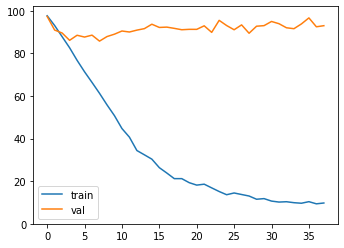

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 285ms/step - loss: 0.6844 - accuracy: 0.5893 - precision: 0.5892 - recall: 0.7475 - f1: 0.6485 - specificity: 0.4423 - negative_predictive_value: 0.6124 - matthews_correlation_coefficient: 0.1953 - equal_error_rate: 0.3841 - val_loss: 0.7076 - val_accuracy: 0.4688 - val_precision: 0.4881 - val_recall: 0.7915 - val_f1: 0.5939 - val_specificity: 0.1680 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: -0.0544 - val_equal_error_rate: 0.5000

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.05444, saving model to ../../models/siamese_networks/looking_away_2020_06_09-21_08_02.h5
Epoch 2/100
7/7 [==============================] - 1s 166ms/step - loss: 0.7353 - accuracy: 0.5225 - precision: 0.5102 - recall: 0.6934 - f1: 0.5803 - specificity: 0.3752 - negative_predictive_value: 0.5663 - matthews_correlation_coefficient: 0.0723 - equal_error_rate: 0.4711 - val_loss: 0.7170 - val_accurac


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 14/100
7/7 [==============================] - 1s 158ms/step - loss: 0.6801 - accuracy: 0.6081 - precision: 0.5784 - recall: 0.6708 - f1: 0.6140 - specificity: 0.5431 - negative_predictive_value: 0.6525 - matthews_correlation_coefficient: 0.2216 - equal_error_rate: 0.4115 - val_loss: 0.8272 - val_accuracy: 0.4688 - val_precision: 0.3667 - val_recall: 0.1032 - val_f1: 0.1566 - val_specificity: 0.8441 - val_negative_predictive_value: 0.4860 - val_matthews_correlation_coefficient: -0.0880 - val_equal_error_rate: 0.4484

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 15/100
7/7 [==============================] - 1s 153ms/step - loss: 0.6580 - accuracy: 0.6036 - precision: 0.6187 - recall: 0.5712 - f1: 0.5893 - specificity: 0.6369 - negative_predictive_value: 0.5878 - matthews_correlation_coefficient: 0.2072 - equal_error_rate: 0.3838 - val_loss: 0.8324 - val_accuracy: 

7/7 [==============================] - 1s 151ms/step - loss: 0.6331 - accuracy: 0.6216 - precision: 0.6070 - recall: 0.6616 - f1: 0.6280 - specificity: 0.5808 - negative_predictive_value: 0.6359 - matthews_correlation_coefficient: 0.2426 - equal_error_rate: 0.3618 - val_loss: 0.8927 - val_accuracy: 0.5156 - val_precision: 0.6667 - val_recall: 0.1032 - val_f1: 0.1788 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5063 - val_matthews_correlation_coefficient: 0.0708 - val_equal_error_rate: 0.4221

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 28/100
7/7 [==============================] - 1s 146ms/step - loss: 0.6534 - accuracy: 0.6306 - precision: 0.6484 - recall: 0.5794 - f1: 0.6066 - specificity: 0.6668 - negative_predictive_value: 0.6021 - matthews_correlation_coefficient: 0.2482 - equal_error_rate: 0.3431 - val_loss: 0.8955 - val_accuracy: 0.5156 - val_precision: 0.6667 - val_recall: 0.1032 - val_f1: 0.1788 - val_specificity: 0.9231


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 41/100
7/7 [==============================] - 1s 149ms/step - loss: 0.6334 - accuracy: 0.6339 - precision: 0.6451 - recall: 0.6570 - f1: 0.6442 - specificity: 0.5879 - negative_predictive_value: 0.6118 - matthews_correlation_coefficient: 0.2508 - equal_error_rate: 0.3569 - val_loss: 0.9198 - val_accuracy: 0.5156 - val_precision: 0.6667 - val_recall: 0.1032 - val_f1: 0.1788 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5063 - val_matthews_correlation_coefficient: 0.0708 - val_equal_error_rate: 0.4352

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 42/100
7/7 [==============================] - 1s 153ms/step - loss: 0.6059 - accuracy: 0.6667 - precision: 0.6396 - recall: 0.7047 - f1: 0.6657 - specificity: 0.6189 - negative_predictive_value: 0.6906 - matthews_correlation_coefficient: 0.3268 - equal_error_rate: 0.2926 - val_loss: 0.9275 - val_accuracy: 0

7/7 [==============================] - 1s 146ms/step - loss: 0.5947 - accuracy: 0.6622 - precision: 0.6298 - recall: 0.6554 - f1: 0.6414 - specificity: 0.6526 - negative_predictive_value: 0.6839 - matthews_correlation_coefficient: 0.3108 - equal_error_rate: 0.3153 - val_loss: 0.9416 - val_accuracy: 0.5156 - val_precision: 0.6667 - val_recall: 0.1032 - val_f1: 0.1788 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5063 - val_matthews_correlation_coefficient: 0.0708 - val_equal_error_rate: 0.4221

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.15801
Epoch 55/100
7/7 [==============================] - 1s 139ms/step - loss: 0.5817 - accuracy: 0.6937 - precision: 0.7162 - recall: 0.6612 - f1: 0.6831 - specificity: 0.7280 - negative_predictive_value: 0.6688 - matthews_correlation_coefficient: 0.3870 - equal_error_rate: 0.2979 - val_loss: 0.9419 - val_accuracy: 0.5156 - val_precision: 0.6667 - val_recall: 0.1032 - val_f1: 0.1788 - val_specificity: 0.9231

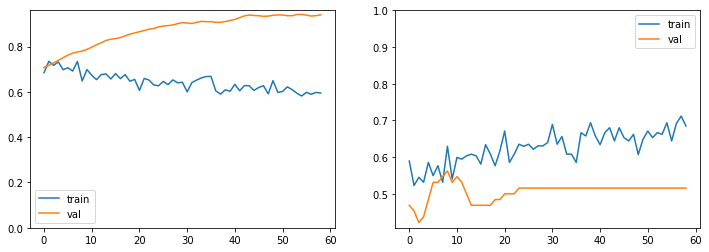

In [16]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)


list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 175ms/step - loss: 90.1894 - val_loss: 118.5598
Epoch 2/100
100/100 [==============================] - 16s 163ms/step - loss: 51.4363 - val_loss: 140.9431
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 34.8423 - val_loss: 135.4504
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 14.8994 - val_loss: 137.8961
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 5.9683 - val_loss: 141.6480
Epoch 6/100
100/100 [==============================] - 16s 163ms/step - loss: 4.4043 - val_loss: 144.5546
Epoch 7/100
100/100 [==============================] - 16s 163ms/step - loss: 2.5354 - val_loss: 144.6423
Epoch 8/100
100/100 [==============================] - 16s 163ms/step - loss: 2.2737 - val_loss: 145.5399
Epoch 9/100
100/100 [==============================] - 16s 163ms/step - loss: 1.8751 - val_loss: 144.7031
Epoch 10/100
100/100 [====================

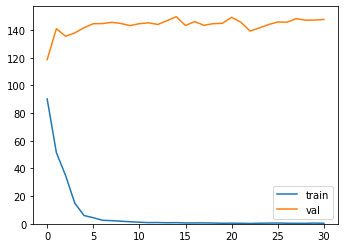

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 561ms/step - loss: 0.7275 - accuracy: 0.5104 - precision: 0.5012 - recall: 0.7227 - f1: 0.5907 - specificity: 0.2701 - negative_predictive_value: 0.4630 - matthews_correlation_coefficient: -0.0196 - equal_error_rate: 0.4185 - val_loss: 0.6266 - val_accuracy: 0.6667 - val_precision: 0.7000 - val_recall: 0.5833 - val_f1: 0.6364 - val_specificity: 0.7500 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.3381 - val_equal_error_rate: 0.2917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33806, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_09-21_17_59.h5
Epoch 2/100
3/3 [==============================] - 1s 215ms/step - loss: 0.7048 - accuracy: 0.5000 - precision: 0.5278 - recall: 0.8142 - f1: 0.6344 - specificity: 0.1436 - negative_predictive_value: 0.2500 - matthews_correlation_coefficient: -0.0484 - equal_error_rate: 0.4133 - val_loss: 0.6267 - val_

3/3 [==============================] - 0s 162ms/step - loss: 0.6538 - accuracy: 0.5147 - precision: 0.5889 - recall: 0.7399 - f1: 0.6520 - specificity: 0.4060 - negative_predictive_value: 0.6111 - matthews_correlation_coefficient: 0.1710 - equal_error_rate: 0.4052 - val_loss: 0.6323 - val_accuracy: 0.6667 - val_precision: 0.7000 - val_recall: 0.5833 - val_f1: 0.6364 - val_specificity: 0.7500 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.3381 - val_equal_error_rate: 0.2917

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33806
Epoch 15/100
3/3 [==============================] - 0s 153ms/step - loss: 0.7883 - accuracy: 0.4559 - precision: 0.4608 - recall: 0.4810 - f1: 0.4668 - specificity: 0.4538 - negative_predictive_value: 0.4778 - matthews_correlation_coefficient: -0.0633 - equal_error_rate: 0.4585 - val_loss: 0.6331 - val_accuracy: 0.6667 - val_precision: 0.7000 - val_recall: 0.5833 - val_f1: 0.6364 - val_specificity: 0.750


Epoch 00027: val_matthews_correlation_coefficient improved from 0.33806 to 0.41812, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_09-21_17_59.h5
Epoch 28/100
3/3 [==============================] - 0s 156ms/step - loss: 0.6623 - accuracy: 0.4559 - precision: 0.4545 - recall: 0.5654 - f1: 0.4950 - specificity: 0.4000 - negative_predictive_value: 0.5095 - matthews_correlation_coefficient: -0.0353 - equal_error_rate: 0.4382 - val_loss: 0.6448 - val_accuracy: 0.7083 - val_precision: 0.7273 - val_recall: 0.6667 - val_f1: 0.6957 - val_specificity: 0.7500 - val_negative_predictive_value: 0.6923 - val_matthews_correlation_coefficient: 0.4181 - val_equal_error_rate: 0.2917

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 29/100
3/3 [==============================] - 1s 169ms/step - loss: 0.7099 - accuracy: 0.5417 - precision: 0.5296 - recall: 0.6403 - f1: 0.5766 - specificity: 0.4316 - negative_predictive_value: 0.5427 - matthews_

3/3 [==============================] - 1s 169ms/step - loss: 0.6972 - accuracy: 0.5312 - precision: 0.5420 - recall: 0.6864 - f1: 0.5876 - specificity: 0.4184 - negative_predictive_value: 0.5731 - matthews_correlation_coefficient: 0.1096 - equal_error_rate: 0.4058 - val_loss: 0.6568 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6667 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.3333 - val_equal_error_rate: 0.2917

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 42/100
3/3 [==============================] - 0s 161ms/step - loss: 0.6855 - accuracy: 0.5294 - precision: 0.5922 - recall: 0.7946 - f1: 0.6770 - specificity: 0.3513 - negative_predictive_value: 0.5952 - matthews_correlation_coefficient: 0.1653 - equal_error_rate: 0.4042 - val_loss: 0.6577 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_f1: 0.6667 - val_specificity: 0.6667


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 55/100
3/3 [==============================] - 0s 163ms/step - loss: 0.7034 - accuracy: 0.4853 - precision: 0.4312 - recall: 0.5716 - f1: 0.4889 - specificity: 0.2526 - negative_predictive_value: 0.3355 - matthews_correlation_coefficient: -0.2025 - equal_error_rate: 0.4495 - val_loss: 0.6551 - val_accuracy: 0.6667 - val_precision: 0.6429 - val_recall: 0.7500 - val_f1: 0.6923 - val_specificity: 0.5833 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.3381 - val_equal_error_rate: 0.2917

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.41812
Epoch 56/100
3/3 [==============================] - 0s 163ms/step - loss: 0.6319 - accuracy: 0.5441 - precision: 0.6417 - recall: 0.7157 - f1: 0.6744 - specificity: 0.6333 - negative_predictive_value: 0.7083 - matthews_correlation_coefficient: 0.3495 - equal_error_rate: 0.3699 - val_loss: 0.6540 - val_accuracy: 

3/3 [==============================] - 1s 167ms/step - loss: 0.6593 - accuracy: 0.5588 - precision: 0.5499 - recall: 0.7631 - f1: 0.6385 - specificity: 0.4611 - negative_predictive_value: 0.7292 - matthews_correlation_coefficient: 0.2496 - equal_error_rate: 0.3953 - val_loss: 0.6585 - val_accuracy: 0.4583 - val_precision: 0.4762 - val_recall: 0.8333 - val_f1: 0.6061 - val_specificity: 0.0833 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.1260 - val_equal_error_rate: 0.2917

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.43033
Epoch 69/100
3/3 [==============================] - 1s 171ms/step - loss: 0.6844 - accuracy: 0.4688 - precision: 0.4941 - recall: 0.6991 - f1: 0.5646 - specificity: 0.2573 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: -0.0596 - equal_error_rate: 0.3854 - val_loss: 0.6582 - val_accuracy: 0.4583 - val_precision: 0.4762 - val_recall: 0.8333 - val_f1: 0.6061 - val_specificity: 0.08


Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.43033
Epoch 82/100
3/3 [==============================] - 1s 170ms/step - loss: 0.6161 - accuracy: 0.5147 - precision: 0.5926 - recall: 0.7420 - f1: 0.6529 - specificity: 0.4094 - negative_predictive_value: 0.6095 - matthews_correlation_coefficient: 0.1748 - equal_error_rate: 0.3954 - val_loss: 0.6667 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8333 - val_f1: 0.6250 - val_specificity: 0.1667 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.2917

Epoch 00082: val_matthews_correlation_coefficient did not improve from 0.43033
Epoch 83/100
3/3 [==============================] - 0s 153ms/step - loss: 0.6387 - accuracy: 0.5882 - precision: 0.6895 - recall: 0.7734 - f1: 0.7232 - specificity: 0.6462 - negative_predictive_value: 0.7329 - matthews_correlation_coefficient: 0.4210 - equal_error_rate: 0.3759 - val_loss: 0.6676 - val_accurac

3/3 [==============================] - 0s 162ms/step - loss: 0.6190 - accuracy: 0.5441 - precision: 0.6667 - recall: 0.7661 - f1: 0.7051 - specificity: 0.5949 - negative_predictive_value: 0.6944 - matthews_correlation_coefficient: 0.3610 - equal_error_rate: 0.3759 - val_loss: 0.6680 - val_accuracy: 0.5417 - val_precision: 0.5263 - val_recall: 0.8333 - val_f1: 0.6452 - val_specificity: 0.2500 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1026 - val_equal_error_rate: 0.4583

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.43033
Epoch 96/100
3/3 [==============================] - 0s 162ms/step - loss: 0.6796 - accuracy: 0.5147 - precision: 0.6333 - recall: 0.7712 - f1: 0.6880 - specificity: 0.5556 - negative_predictive_value: 0.6889 - matthews_correlation_coefficient: 0.3246 - equal_error_rate: 0.4064 - val_loss: 0.6698 - val_accuracy: 0.5417 - val_precision: 0.5263 - val_recall: 0.8333 - val_f1: 0.6452 - val_specificity: 0.2500

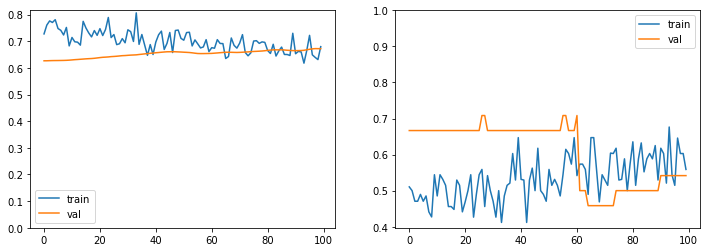

In [18]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 190ms/step - loss: 81.7947 - val_loss: 77.2755
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 54.9027 - val_loss: 84.1573
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 33.9318 - val_loss: 82.9756
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 18.0022 - val_loss: 78.9325
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 9.4073 - val_loss: 77.0406
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 5.4708 - val_loss: 72.3147
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 3.2626 - val_loss: 67.9015
Epoch 8/100
100/100 [==============================] - 18s 176ms/step - loss: 2.5044 - val_loss: 72.4178
Epoch 9/100
100/100 [==============================] - 18s 177ms/step - loss: 1.9512 - val_loss: 68.4891
Epoch 10/100
100/100 [=============================

100/100 [==============================] - 18s 177ms/step - loss: 0.1616 - val_loss: 66.4137
Epoch 79/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2800 - val_loss: 68.5210
Epoch 80/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2379 - val_loss: 64.8039
Epoch 81/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1403 - val_loss: 63.6537
Epoch 82/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0357 - val_loss: 65.5747
Epoch 83/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1548 - val_loss: 66.4287
Epoch 84/100
100/100 [==============================] - 18s 177ms/step - loss: 0.1016 - val_loss: 65.4982
Restoring model weights from the end of the best epoch
Epoch 00084: early stopping


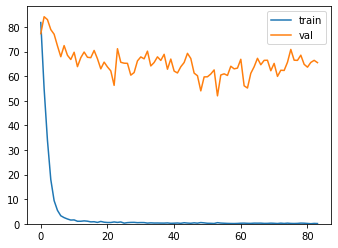

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 652ms/step - loss: 0.6615 - accuracy: 0.5833 - precision: 0.5657 - recall: 0.7765 - f1: 0.6523 - specificity: 0.3833 - negative_predictive_value: 0.5927 - matthews_correlation_coefficient: 0.1597 - equal_error_rate: 0.3335 - val_loss: 1.2232 - val_accuracy: 0.2903 - val_precision: 0.3600 - val_recall: 0.6000 - val_f1: 0.4500 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.5060 - val_equal_error_rate: 0.5813

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.50596, saving model to ../../models/siamese_networks/too_dark_light_2020_06_09-21_44_19.h5
Epoch 2/100
3/3 [==============================] - 1s 290ms/step - loss: 0.6619 - accuracy: 0.6087 - precision: 0.6004 - recall: 0.7222 - f1: 0.6451 - specificity: 0.5106 - negative_predictive_value: 0.6494 - matthews_correlation_coefficient: 0.2409 - equal_error_rate: 0.3373 - val_loss: 1.2192 - v

3/3 [==============================] - 0s 153ms/step - loss: 0.5018 - accuracy: 0.7717 - precision: 0.8928 - recall: 0.6376 - f1: 0.7426 - specificity: 0.9048 - negative_predictive_value: 0.7088 - matthews_correlation_coefficient: 0.5707 - equal_error_rate: 0.2262 - val_loss: 1.2410 - val_accuracy: 0.3548 - val_precision: 0.3810 - val_recall: 0.5333 - val_f1: 0.4444 - val_specificity: 0.1875 - val_negative_predictive_value: 0.3000 - val_matthews_correlation_coefficient: -0.2984 - val_equal_error_rate: 0.5813

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.29844
Epoch 15/100
3/3 [==============================] - 0s 162ms/step - loss: 0.4745 - accuracy: 0.7935 - precision: 0.9190 - recall: 0.6310 - f1: 0.7389 - specificity: 0.9345 - negative_predictive_value: 0.7400 - matthews_correlation_coefficient: 0.6087 - equal_error_rate: 0.2743 - val_loss: 1.2531 - val_accuracy: 0.3548 - val_precision: 0.3913 - val_recall: 0.6000 - val_f1: 0.4737 - val_specificity: 0.12

3/3 [==============================] - 1s 173ms/step - loss: 0.2747 - accuracy: 0.9022 - precision: 0.9608 - recall: 0.8363 - f1: 0.8885 - specificity: 0.9583 - negative_predictive_value: 0.8755 - matthews_correlation_coefficient: 0.8149 - equal_error_rate: 0.1063 - val_loss: 1.3731 - val_accuracy: 0.4516 - val_precision: 0.4615 - val_recall: 0.8000 - val_f1: 0.5854 - val_specificity: 0.1250 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1019 - val_equal_error_rate: 0.5813

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.01581
Epoch 28/100
3/3 [==============================] - 0s 159ms/step - loss: 0.3791 - accuracy: 0.8587 - precision: 0.9262 - recall: 0.7943 - f1: 0.8540 - specificity: 0.9315 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.7289 - equal_error_rate: 0.1397 - val_loss: 1.3840 - val_accuracy: 0.4516 - val_precision: 0.4615 - val_recall: 0.8000 - val_f1: 0.5854 - val_specificity: 0.12


Epoch 00040: val_matthews_correlation_coefficient did not improve from -0.01581
Epoch 41/100
3/3 [==============================] - 1s 189ms/step - loss: 0.2666 - accuracy: 0.8750 - precision: 0.9167 - recall: 0.8208 - f1: 0.8594 - specificity: 0.9101 - negative_predictive_value: 0.8594 - matthews_correlation_coefficient: 0.7529 - equal_error_rate: 0.0832 - val_loss: 1.4925 - val_accuracy: 0.4516 - val_precision: 0.4615 - val_recall: 0.8000 - val_f1: 0.5854 - val_specificity: 0.1250 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1019 - val_equal_error_rate: 0.5813

Epoch 00041: val_matthews_correlation_coefficient did not improve from -0.01581
Epoch 42/100
3/3 [==============================] - 1s 181ms/step - loss: 0.3571 - accuracy: 0.8804 - precision: 0.9444 - recall: 0.8254 - f1: 0.8788 - specificity: 0.9286 - negative_predictive_value: 0.8364 - matthews_correlation_coefficient: 0.7673 - equal_error_rate: 0.1534 - val_loss: 1.4977 - val_accuracy

3/3 [==============================] - 0s 166ms/step - loss: 0.2695 - accuracy: 0.9130 - precision: 0.9351 - recall: 0.8968 - f1: 0.9153 - specificity: 0.9339 - negative_predictive_value: 0.8982 - matthews_correlation_coefficient: 0.8320 - equal_error_rate: 0.0847 - val_loss: 1.5802 - val_accuracy: 0.4516 - val_precision: 0.4643 - val_recall: 0.8667 - val_f1: 0.6047 - val_specificity: 0.0625 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.1197 - val_equal_error_rate: 0.5813

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 55/100
3/3 [==============================] - 1s 169ms/step - loss: 0.2288 - accuracy: 0.9022 - precision: 0.9521 - recall: 0.8393 - f1: 0.8907 - specificity: 0.9554 - negative_predictive_value: 0.8687 - matthews_correlation_coefficient: 0.8075 - equal_error_rate: 0.0881 - val_loss: 1.5799 - val_accuracy: 0.4516 - val_precision: 0.4643 - val_recall: 0.8667 - val_f1: 0.6047 - val_specificity: 0.062


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 68/100
3/3 [==============================] - 1s 175ms/step - loss: 0.3023 - accuracy: 0.8804 - precision: 0.9298 - recall: 0.8522 - f1: 0.8862 - specificity: 0.9048 - negative_predictive_value: 0.8446 - matthews_correlation_coefficient: 0.7656 - equal_error_rate: 0.0951 - val_loss: 1.4870 - val_accuracy: 0.4839 - val_precision: 0.4815 - val_recall: 0.8667 - val_f1: 0.6190 - val_specificity: 0.1250 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0124 - val_equal_error_rate: 0.5167

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 69/100
3/3 [==============================] - 0s 157ms/step - loss: 0.2818 - accuracy: 0.9062 - precision: 0.9608 - recall: 0.8522 - f1: 0.9016 - specificity: 0.9524 - negative_predictive_value: 0.8661 - matthews_correlation_coefficient: 0.8155 - equal_error_rate: 0.1043 - val_loss: 1.4841 - val_accuracy: 

3/3 [==============================] - 0s 160ms/step - loss: 0.3522 - accuracy: 0.8750 - precision: 0.9361 - recall: 0.8128 - f1: 0.8689 - specificity: 0.9315 - negative_predictive_value: 0.8298 - matthews_correlation_coefficient: 0.7549 - equal_error_rate: 0.1463 - val_loss: 1.4595 - val_accuracy: 0.4516 - val_precision: 0.4615 - val_recall: 0.8000 - val_f1: 0.5854 - val_specificity: 0.1250 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1019 - val_equal_error_rate: 0.4521

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 82/100
3/3 [==============================] - 0s 158ms/step - loss: 0.3827 - accuracy: 0.8370 - precision: 0.9155 - recall: 0.7593 - f1: 0.8238 - specificity: 0.9101 - negative_predictive_value: 0.7883 - matthews_correlation_coefficient: 0.6860 - equal_error_rate: 0.1508 - val_loss: 1.4612 - val_accuracy: 0.4516 - val_precision: 0.4615 - val_recall: 0.8000 - val_f1: 0.5854 - val_specificity: 0.125


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 95/100
3/3 [==============================] - 1s 170ms/step - loss: 0.2247 - accuracy: 0.9239 - precision: 0.9608 - recall: 0.8839 - f1: 0.9174 - specificity: 0.9583 - negative_predictive_value: 0.9014 - matthews_correlation_coefficient: 0.8521 - equal_error_rate: 0.0673 - val_loss: 1.4116 - val_accuracy: 0.4194 - val_precision: 0.4400 - val_recall: 0.7333 - val_f1: 0.5500 - val_specificity: 0.1250 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.1792 - val_equal_error_rate: 0.3875

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.07360
Epoch 96/100
3/3 [==============================] - 1s 175ms/step - loss: 0.2748 - accuracy: 0.8913 - precision: 0.9317 - recall: 0.8581 - f1: 0.8908 - specificity: 0.9315 - negative_predictive_value: 0.8600 - matthews_correlation_coefficient: 0.7907 - equal_error_rate: 0.0974 - val_loss: 1.4087 - val_accuracy: 

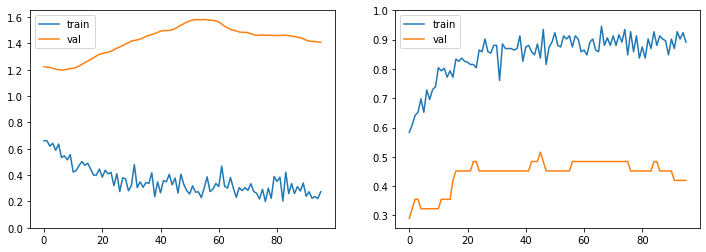

In [20]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 170ms/step - loss: 95.4039 - val_loss: 73.2906
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 73.8638 - val_loss: 54.0925
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 55.3585 - val_loss: 30.0800
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 29.9643 - val_loss: 28.7289
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 14.2989 - val_loss: 15.4181
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 7.2531 - val_loss: 12.2363
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 4.2618 - val_loss: 11.1387
Epoch 8/100
100/100 [==============================] - 16s 156ms/step - loss: 3.0013 - val_loss: 11.1542
Epoch 9/100
100/100 [==============================] - 16s 156ms/step - loss: 2.3928 - val_loss: 11.1706
Epoch 10/100
100/100 [============================

100/100 [==============================] - 16s 156ms/step - loss: 0.1316 - val_loss: 13.5594
Epoch 79/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1986 - val_loss: 15.7783
Epoch 80/100
100/100 [==============================] - 16s 156ms/step - loss: 0.3033 - val_loss: 15.7020
Epoch 81/100
100/100 [==============================] - 16s 156ms/step - loss: 0.2225 - val_loss: 18.1021
Epoch 82/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1648 - val_loss: 14.8668
Epoch 83/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1311 - val_loss: 19.2453
Epoch 84/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1428 - val_loss: 17.9692
Restoring model weights from the end of the best epoch
Epoch 00084: early stopping


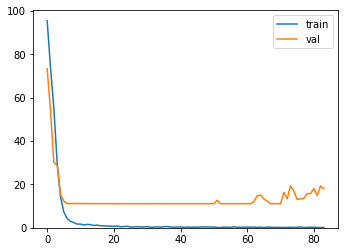

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 534ms/step - loss: 0.6229 - accuracy: 0.6771 - precision: 0.6588 - recall: 0.6994 - f1: 0.6771 - specificity: 0.6574 - negative_predictive_value: 0.6966 - matthews_correlation_coefficient: 0.3561 - equal_error_rate: 0.3138 - val_loss: 0.4358 - val_accuracy: 0.8800 - val_precision: 1.0000 - val_recall: 0.7857 - val_f1: 0.8800 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7857 - val_matthews_correlation_coefficient: 0.7857 - val_equal_error_rate: 0.0357

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.78571, saving model to ../../models/siamese_networks/washed_out_2020_06_09-22_07_44.h5
Epoch 2/100
3/3 [==============================] - 1s 186ms/step - loss: 0.5758 - accuracy: 0.6915 - precision: 0.6611 - recall: 0.8346 - f1: 0.7362 - specificity: 0.5240 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.3896 - equal_error_rate: 0.2768 - val_loss: 0.4268 - val_accuracy: 0

3/3 [==============================] - 0s 152ms/step - loss: 0.3166 - accuracy: 0.9043 - precision: 0.9166 - recall: 0.8958 - f1: 0.9027 - specificity: 0.9119 - negative_predictive_value: 0.9076 - matthews_correlation_coefficient: 0.8159 - equal_error_rate: 0.0741 - val_loss: 0.3798 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.7143 - val_f1: 0.8333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7333 - val_matthews_correlation_coefficient: 0.7237 - val_equal_error_rate: 0.0357

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 15/100
3/3 [==============================] - 0s 135ms/step - loss: 0.3115 - accuracy: 0.8936 - precision: 0.8944 - recall: 0.8953 - f1: 0.8930 - specificity: 0.8980 - negative_predictive_value: 0.8923 - matthews_correlation_coefficient: 0.7900 - equal_error_rate: 0.1060 - val_loss: 0.3773 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.7143 - val_f1: 0.8333 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 28/100
3/3 [==============================] - 0s 153ms/step - loss: 0.2264 - accuracy: 0.9681 - precision: 0.9792 - recall: 0.9554 - f1: 0.9668 - specificity: 0.9792 - negative_predictive_value: 0.9616 - matthews_correlation_coefficient: 0.9376 - equal_error_rate: 0.0530 - val_loss: 0.3638 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.7143 - val_f1: 0.8333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7333 - val_matthews_correlation_coefficient: 0.7237 - val_equal_error_rate: 0.0357

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 29/100
3/3 [==============================] - 0s 151ms/step - loss: 0.2065 - accuracy: 0.9479 - precision: 0.9412 - recall: 0.9554 - f1: 0.9473 - specificity: 0.9375 - negative_predictive_value: 0.9602 - matthews_correlation_coefficient: 0.8971 - equal_error_rate: 0.0536 - val_loss: 0.3651 - val_accuracy: 0

3/3 [==============================] - 0s 154ms/step - loss: 0.1192 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.9762 - f1: 0.9877 - specificity: 1.0000 - negative_predictive_value: 0.9825 - matthews_correlation_coefficient: 0.9793 - equal_error_rate: 0.0327 - val_loss: 0.3642 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.7143 - val_f1: 0.8333 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7333 - val_matthews_correlation_coefficient: 0.7237 - val_equal_error_rate: 0.0357

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.78571
Epoch 42/100
3/3 [==============================] - 0s 140ms/step - loss: 0.1541 - accuracy: 0.9681 - precision: 0.9804 - recall: 0.9583 - f1: 0.9677 - specificity: 0.9792 - negative_predictive_value: 0.9630 - matthews_correlation_coefficient: 0.9404 - equal_error_rate: 0.0306 - val_loss: 0.3626 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.7143 - val_f1: 0.8333 - val_specificity: 1.0000

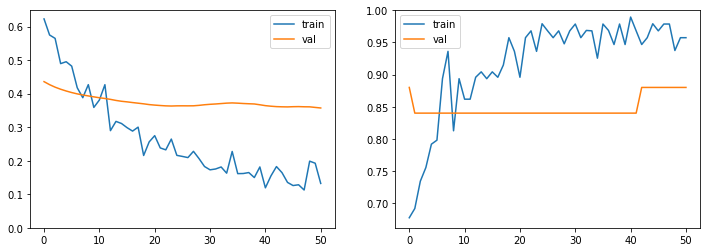

In [22]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 194ms/step - loss: 96.4764 - val_loss: 90.0468
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 87.7780 - val_loss: 76.5409
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 76.4378 - val_loss: 79.3103
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 66.2841 - val_loss: 79.1587
Epoch 5/100
100/100 [==============================] - 18s 181ms/step - loss: 57.7849 - val_loss: 74.0081
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 53.8943 - val_loss: 78.8893
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 49.9834 - val_loss: 76.0531
Epoch 8/100
100/100 [==============================] - 18s 181ms/step - loss: 46.5726 - val_loss: 72.2319
Epoch 9/100
100/100 [==============================] - 18s 181ms/step - loss: 44.1629 - val_loss: 68.7576
Epoch 10/100
100/100 [========================

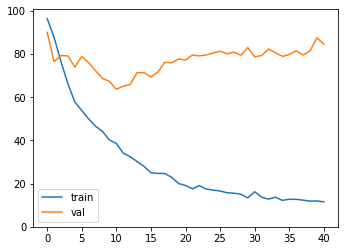

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
5/5 [==============================] - 2s 429ms/step - loss: 0.7747 - accuracy: 0.4938 - precision: 0.5002 - recall: 0.6808 - f1: 0.5719 - specificity: 0.3067 - negative_predictive_value: 0.4722 - matthews_correlation_coefficient: -0.0196 - equal_error_rate: 0.4939 - val_loss: 0.7846 - val_accuracy: 0.4375 - val_precision: 0.4286 - val_recall: 0.8571 - val_f1: 0.5714 - val_specificity: 0.1111 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0476 - val_equal_error_rate: 0.5992

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.04762, saving model to ../../models/siamese_networks/pixelation_2020_06_09-22_21_21.h5
Epoch 2/100
5/5 [==============================] - 1s 199ms/step - loss: 0.7514 - accuracy: 0.5294 - precision: 0.5439 - recall: 0.6611 - f1: 0.5899 - specificity: 0.4313 - negative_predictive_value: 0.5573 - matthews_correlation_coefficient: 0.0967 - equal_error_rate: 0.5127 - val_loss: 0.7777 - val_accuracy

5/5 [==============================] - 1s 148ms/step - loss: 0.6055 - accuracy: 0.6912 - precision: 0.6695 - recall: 0.6903 - f1: 0.6728 - specificity: 0.6468 - negative_predictive_value: 0.6652 - matthews_correlation_coefficient: 0.3359 - equal_error_rate: 0.2997 - val_loss: 0.8404 - val_accuracy: 0.4688 - val_precision: 0.4348 - val_recall: 0.7143 - val_f1: 0.5405 - val_specificity: 0.2778 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: -0.0088 - val_equal_error_rate: 0.4087

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.26227
Epoch 15/100
5/5 [==============================] - 1s 149ms/step - loss: 0.5040 - accuracy: 0.7868 - precision: 0.7895 - recall: 0.7918 - f1: 0.7857 - specificity: 0.8122 - negative_predictive_value: 0.8190 - matthews_correlation_coefficient: 0.6061 - equal_error_rate: 0.2700 - val_loss: 0.8469 - val_accuracy: 0.4688 - val_precision: 0.4348 - val_recall: 0.7143 - val_f1: 0.5405 - val_specificity: 0.277


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.26227
Epoch 28/100
5/5 [==============================] - 1s 146ms/step - loss: 0.5587 - accuracy: 0.7206 - precision: 0.7454 - recall: 0.6431 - f1: 0.6719 - specificity: 0.7506 - negative_predictive_value: 0.6710 - matthews_correlation_coefficient: 0.4046 - equal_error_rate: 0.2552 - val_loss: 0.9630 - val_accuracy: 0.4688 - val_precision: 0.4348 - val_recall: 0.7143 - val_f1: 0.5405 - val_specificity: 0.2778 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: -0.0088 - val_equal_error_rate: 0.4087

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.26227
Epoch 29/100
5/5 [==============================] - 1s 146ms/step - loss: 0.5591 - accuracy: 0.7059 - precision: 0.7268 - recall: 0.6802 - f1: 0.6920 - specificity: 0.7112 - negative_predictive_value: 0.6740 - matthews_correlation_coefficient: 0.3960 - equal_error_rate: 0.2681 - val_loss: 0.9688 - val_accuracy: 

5/5 [==============================] - 1s 136ms/step - loss: 0.5298 - accuracy: 0.7500 - precision: 0.8118 - recall: 0.6926 - f1: 0.7360 - specificity: 0.8224 - negative_predictive_value: 0.7180 - matthews_correlation_coefficient: 0.5222 - equal_error_rate: 0.2946 - val_loss: 1.0137 - val_accuracy: 0.4688 - val_precision: 0.4348 - val_recall: 0.7143 - val_f1: 0.5405 - val_specificity: 0.2778 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: -0.0088 - val_equal_error_rate: 0.4087

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.26227
Epoch 42/100
5/5 [==============================] - 1s 138ms/step - loss: 0.5070 - accuracy: 0.7574 - precision: 0.8064 - recall: 0.6924 - f1: 0.7310 - specificity: 0.8099 - negative_predictive_value: 0.7362 - matthews_correlation_coefficient: 0.5212 - equal_error_rate: 0.2572 - val_loss: 1.0161 - val_accuracy: 0.4688 - val_precision: 0.4348 - val_recall: 0.7143 - val_f1: 0.5405 - val_specificity: 0.277

Restoring model weights from the end of the best epoch

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.26227
Epoch 00054: early stopping

   Final Accuracy:  54.05%
  Final Precision:  48.28%
     Final Recall:  87.50%
  Final F-measure:  62.22%
Final Specificity:  28.57%
        Final NPV:  75.00%
        Final MCC:  19.34%

[[ 6 15]
 [ 2 14]]
              precision    recall  f1-score   support

           0       0.75      0.29      0.41        21
           1       0.48      0.88      0.62        16

    accuracy                           0.54        37
   macro avg       0.62      0.58      0.52        37
weighted avg       0.63      0.54      0.50        37



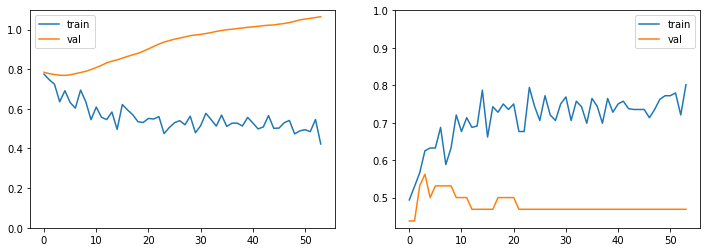

In [24]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 253ms/step - loss: 92.2877 - val_loss: 105.0361
Epoch 2/100
100/100 [==============================] - 24s 239ms/step - loss: 77.5553 - val_loss: 110.1273
Epoch 3/100
100/100 [==============================] - 24s 240ms/step - loss: 69.5354 - val_loss: 116.0871
Epoch 4/100
100/100 [==============================] - 24s 239ms/step - loss: 62.6670 - val_loss: 112.3280
Epoch 5/100
100/100 [==============================] - 24s 239ms/step - loss: 54.8989 - val_loss: 120.6219
Epoch 6/100
100/100 [==============================] - 24s 239ms/step - loss: 49.3242 - val_loss: 114.2645
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 44.6305 - val_loss: 112.6886
Epoch 8/100
100/100 [==============================] - 24s 239ms/step - loss: 36.8156 - val_loss: 111.3881
Epoch 9/100
100/100 [==============================] - 24s 239ms/step - loss: 32.6865 - val_loss: 112.9919
Epoch 10/100
100/100 [===============

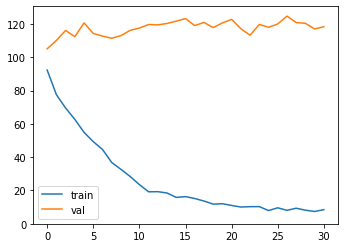

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
9/9 [==============================] - 3s 308ms/step - loss: 0.7166 - accuracy: 0.5347 - precision: 0.5291 - recall: 0.5649 - f1: 0.5433 - specificity: 0.5007 - negative_predictive_value: 0.5349 - matthews_correlation_coefficient: 0.0648 - equal_error_rate: 0.4553 - val_loss: 0.6748 - val_accuracy: 0.5625 - val_precision: 0.5833 - val_recall: 0.2778 - val_f1: 0.3667 - val_specificity: 0.8286 - val_negative_predictive_value: 0.5641 - val_matthews_correlation_coefficient: 0.1250 - val_equal_error_rate: 0.4696

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12497, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_09-22_35_35.h5
Epoch 2/100
9/9 [==============================] - 1s 156ms/step - loss: 0.7145 - accuracy: 0.5312 - precision: 0.5265 - recall: 0.6421 - f1: 0.5725 - specificity: 0.4216 - negative_predictive_value: 0.5369 - matthews_correlation_coefficient: 0.0635 - equal_error_rate: 0.4413 - val_loss: 0.6741 - val_accur

9/9 [==============================] - 1s 150ms/step - loss: 0.7173 - accuracy: 0.5104 - precision: 0.5137 - recall: 0.5728 - f1: 0.5343 - specificity: 0.4528 - negative_predictive_value: 0.5030 - matthews_correlation_coefficient: 0.0214 - equal_error_rate: 0.4686 - val_loss: 0.6623 - val_accuracy: 0.5469 - val_precision: 0.5500 - val_recall: 0.2500 - val_f1: 0.3304 - val_specificity: 0.8286 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.0908 - val_equal_error_rate: 0.5014

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.12497
Epoch 15/100
9/9 [==============================] - 1s 159ms/step - loss: 0.7152 - accuracy: 0.5035 - precision: 0.5008 - recall: 0.5721 - f1: 0.5289 - specificity: 0.4341 - negative_predictive_value: 0.5070 - matthews_correlation_coefficient: 0.0069 - equal_error_rate: 0.4552 - val_loss: 0.6622 - val_accuracy: 0.5469 - val_precision: 0.5500 - val_recall: 0.2500 - val_f1: 0.3304 - val_specificity: 0.8286


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.12497
Epoch 28/100
9/9 [==============================] - 1s 152ms/step - loss: 0.6502 - accuracy: 0.5694 - precision: 0.5553 - recall: 0.6677 - f1: 0.6001 - specificity: 0.4641 - negative_predictive_value: 0.5852 - matthews_correlation_coefficient: 0.1360 - equal_error_rate: 0.3889 - val_loss: 0.6558 - val_accuracy: 0.5469 - val_precision: 0.5500 - val_recall: 0.2500 - val_f1: 0.3304 - val_specificity: 0.8286 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.0908 - val_equal_error_rate: 0.4224

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.12497
Epoch 29/100
9/9 [==============================] - 1s 150ms/step - loss: 0.6678 - accuracy: 0.5764 - precision: 0.5564 - recall: 0.6595 - f1: 0.6009 - specificity: 0.4802 - negative_predictive_value: 0.5886 - matthews_correlation_coefficient: 0.1423 - equal_error_rate: 0.4104 - val_loss: 0.6552 - val_accuracy: 0

9/9 [==============================] - 1s 153ms/step - loss: 0.6790 - accuracy: 0.5486 - precision: 0.5428 - recall: 0.6605 - f1: 0.5891 - specificity: 0.4482 - negative_predictive_value: 0.5655 - matthews_correlation_coefficient: 0.1085 - equal_error_rate: 0.4071 - val_loss: 0.6509 - val_accuracy: 0.5625 - val_precision: 0.5833 - val_recall: 0.2778 - val_f1: 0.3667 - val_specificity: 0.8286 - val_negative_predictive_value: 0.5641 - val_matthews_correlation_coefficient: 0.1250 - val_equal_error_rate: 0.4046

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.12497
Epoch 42/100
9/9 [==============================] - 1s 150ms/step - loss: 0.6783 - accuracy: 0.5625 - precision: 0.5616 - recall: 0.6213 - f1: 0.5817 - specificity: 0.5163 - negative_predictive_value: 0.5770 - matthews_correlation_coefficient: 0.1381 - equal_error_rate: 0.4152 - val_loss: 0.6501 - val_accuracy: 0.5625 - val_precision: 0.5833 - val_recall: 0.2778 - val_f1: 0.3667 - val_specificity: 0.8286

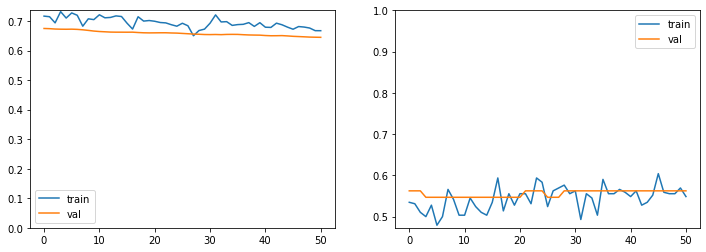

In [26]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 198ms/step - loss: 84.3419 - val_loss: 73.5122
Epoch 2/100
100/100 [==============================] - 18s 183ms/step - loss: 62.6029 - val_loss: 70.4595
Epoch 3/100
100/100 [==============================] - 18s 183ms/step - loss: 45.2676 - val_loss: 68.9032
Epoch 4/100
100/100 [==============================] - 18s 183ms/step - loss: 27.4599 - val_loss: 75.2381
Epoch 5/100
100/100 [==============================] - 18s 183ms/step - loss: 15.9304 - val_loss: 76.3579
Epoch 6/100
100/100 [==============================] - 18s 183ms/step - loss: 11.1410 - val_loss: 74.9768
Epoch 7/100
100/100 [==============================] - 18s 183ms/step - loss: 8.5627 - val_loss: 77.6522
Epoch 8/100
100/100 [==============================] - 18s 183ms/step - loss: 7.1464 - val_loss: 74.7491
Epoch 9/100
100/100 [==============================] - 18s 183ms/step - loss: 4.4620 - val_loss: 71.0626
Epoch 10/100
100/100 [===========================

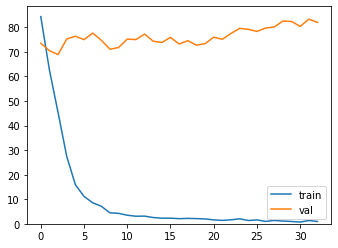

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
6/6 [==============================] - 3s 433ms/step - loss: 0.8571 - accuracy: 0.4635 - precision: 0.4834 - recall: 0.7338 - f1: 0.5741 - specificity: 0.1874 - negative_predictive_value: 0.3687 - matthews_correlation_coefficient: -0.1087 - equal_error_rate: 0.5370 - val_loss: 0.9022 - val_accuracy: 0.4688 - val_precision: 0.5385 - val_recall: 0.7368 - val_f1: 0.6222 - val_specificity: 0.0769 - val_negative_predictive_value: 0.1667 - val_matthews_correlation_coefficient: -0.2343 - val_equal_error_rate: 0.6235

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.23434, saving model to ../../models/siamese_networks/eyes_closed_2020_06_09-22_47_58.h5
Epoch 2/100
6/6 [==============================] - 1s 172ms/step - loss: 0.8015 - accuracy: 0.4268 - precision: 0.4846 - recall: 0.7094 - f1: 0.5632 - specificity: 0.2402 - negative_predictive_value: 0.3722 - matthews_correlation_coefficient: -0.0933 - equal_error_rate: 0.5475 - val_loss: 0.8987 - val_accura

6/6 [==============================] - 1s 151ms/step - loss: 0.6857 - accuracy: 0.5915 - precision: 0.5607 - recall: 0.7200 - f1: 0.5987 - specificity: 0.5055 - negative_predictive_value: 0.6464 - matthews_correlation_coefficient: 0.2160 - equal_error_rate: 0.4168 - val_loss: 0.8875 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2660 - val_equal_error_rate: 0.7146

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.23434
Epoch 15/100
6/6 [==============================] - 1s 147ms/step - loss: 0.6264 - accuracy: 0.6510 - precision: 0.6445 - recall: 0.6323 - f1: 0.6338 - specificity: 0.6495 - negative_predictive_value: 0.6285 - matthews_correlation_coefficient: 0.2773 - equal_error_rate: 0.3542 - val_loss: 0.8930 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specifici

6/6 [==============================] - 1s 150ms/step - loss: 0.6620 - accuracy: 0.5915 - precision: 0.5170 - recall: 0.6791 - f1: 0.5634 - specificity: 0.5317 - negative_predictive_value: 0.6843 - matthews_correlation_coefficient: 0.2058 - equal_error_rate: 0.4419 - val_loss: 1.0095 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2660 - val_equal_error_rate: 0.7146

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.23434
Epoch 28/100
6/6 [==============================] - 1s 154ms/step - loss: 0.5848 - accuracy: 0.6524 - precision: 0.6961 - recall: 0.7109 - f1: 0.6931 - specificity: 0.6751 - negative_predictive_value: 0.6944 - matthews_correlation_coefficient: 0.3878 - equal_error_rate: 0.3856 - val_loss: 1.0161 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specifici

6/6 [==============================] - 1s 138ms/step - loss: 0.5707 - accuracy: 0.7317 - precision: 0.6500 - recall: 0.5359 - f1: 0.5824 - specificity: 0.8430 - negative_predictive_value: 0.6967 - matthews_correlation_coefficient: 0.3832 - equal_error_rate: 0.3660 - val_loss: 1.0467 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2660 - val_equal_error_rate: 0.7146

Epoch 00040: val_matthews_correlation_coefficient did not improve from -0.23434
Epoch 41/100
6/6 [==============================] - 1s 147ms/step - loss: 0.5820 - accuracy: 0.7500 - precision: 0.6827 - recall: 0.7438 - f1: 0.6730 - specificity: 0.6786 - negative_predictive_value: 0.6162 - matthews_correlation_coefficient: 0.4231 - equal_error_rate: 0.2976 - val_loss: 1.0563 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specifici

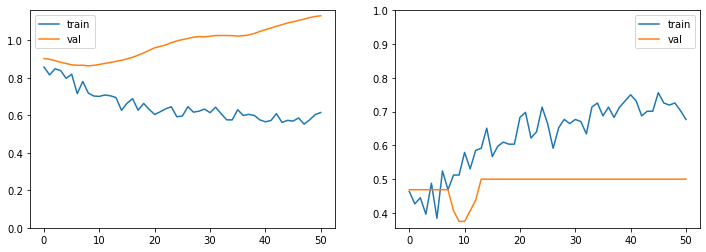

In [28]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 246ms/step - loss: 82.1825 - val_loss: 67.1695
Epoch 2/100
100/100 [==============================] - 22s 223ms/step - loss: 54.1777 - val_loss: 59.3688
Epoch 3/100
100/100 [==============================] - 22s 222ms/step - loss: 24.5183 - val_loss: 51.1336
Epoch 4/100
100/100 [==============================] - 22s 222ms/step - loss: 9.7238 - val_loss: 44.7913
Epoch 5/100
100/100 [==============================] - 22s 223ms/step - loss: 7.0191 - val_loss: 50.0082
Epoch 6/100
100/100 [==============================] - 22s 222ms/step - loss: 5.0187 - val_loss: 45.9020
Epoch 7/100
100/100 [==============================] - 22s 223ms/step - loss: 3.9311 - val_loss: 51.8913
Epoch 8/100
100/100 [==============================] - 22s 222ms/step - loss: 2.5424 - val_loss: 52.4746
Epoch 9/100
100/100 [==============================] - 22s 223ms/step - loss: 1.9742 - val_loss: 52.9479
Epoch 10/100
100/100 [==============================

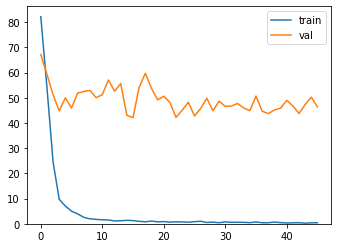

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 417ms/step - loss: 0.8936 - accuracy: 0.4196 - precision: 0.4505 - recall: 0.6860 - f1: 0.5400 - specificity: 0.1439 - negative_predictive_value: 0.3172 - matthews_correlation_coefficient: -0.1975 - equal_error_rate: 0.5531 - val_loss: 0.8681 - val_accuracy: 0.2812 - val_precision: 0.3750 - val_recall: 0.5294 - val_f1: 0.4390 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.5423 - val_equal_error_rate: 0.5608

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.54233, saving model to ../../models/siamese_networks/varied_background_2020_06_09-23_07_10.h5
Epoch 2/100
7/7 [==============================] - 1s 169ms/step - loss: 0.8627 - accuracy: 0.4615 - precision: 0.4838 - recall: 0.6396 - f1: 0.5416 - specificity: 0.2910 - negative_predictive_value: 0.4377 - matthews_correlation_coefficient: -0.0736 - equal_error_rate: 0.5010 - val_loss: 0.788

7/7 [==============================] - 1s 144ms/step - loss: 0.4786 - accuracy: 0.7692 - precision: 0.7740 - recall: 0.7321 - f1: 0.7510 - specificity: 0.7970 - negative_predictive_value: 0.7535 - matthews_correlation_coefficient: 0.5283 - equal_error_rate: 0.2279 - val_loss: 0.4116 - val_accuracy: 0.8750 - val_precision: 0.8095 - val_recall: 1.0000 - val_f1: 0.8947 - val_specificity: 0.7333 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.7705 - val_equal_error_rate: 0.2471

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.77049
Epoch 14/100
7/7 [==============================] - 1s 138ms/step - loss: 0.4227 - accuracy: 0.8510 - precision: 0.9131 - recall: 0.7931 - f1: 0.8443 - specificity: 0.8975 - negative_predictive_value: 0.8198 - matthews_correlation_coefficient: 0.7111 - equal_error_rate: 0.1931 - val_loss: 0.3997 - val_accuracy: 0.8750 - val_precision: 0.8095 - val_recall: 1.0000 - val_f1: 0.8947 - val_specificity: 0.7333

7/7 [==============================] - 1s 133ms/step - loss: 0.4121 - accuracy: 0.8317 - precision: 0.8948 - recall: 0.7590 - f1: 0.8104 - specificity: 0.8808 - negative_predictive_value: 0.8005 - matthews_correlation_coefficient: 0.6663 - equal_error_rate: 0.1962 - val_loss: 0.3412 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.8246 - val_equal_error_rate: 0.1549

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 27/100
7/7 [==============================] - 1s 139ms/step - loss: 0.3043 - accuracy: 0.9038 - precision: 0.9369 - recall: 0.8774 - f1: 0.9044 - specificity: 0.9316 - negative_predictive_value: 0.8919 - matthews_correlation_coefficient: 0.8187 - equal_error_rate: 0.1235 - val_loss: 0.3416 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 40/100
7/7 [==============================] - 1s 133ms/step - loss: 0.3603 - accuracy: 0.8462 - precision: 0.8769 - recall: 0.7571 - f1: 0.8035 - specificity: 0.8958 - negative_predictive_value: 0.8303 - matthews_correlation_coefficient: 0.6786 - equal_error_rate: 0.1858 - val_loss: 0.3297 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.8246 - val_equal_error_rate: 0.1549

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 41/100
7/7 [==============================] - 1s 144ms/step - loss: 0.3020 - accuracy: 0.8884 - precision: 0.9170 - recall: 0.8645 - f1: 0.8815 - specificity: 0.8924 - negative_predictive_value: 0.8933 - matthews_correlation_coefficient: 0.7825 - equal_error_rate: 0.1152 - val_loss: 0.3283 - val_accuracy: 0

7/7 [==============================] - 1s 137ms/step - loss: 0.3611 - accuracy: 0.8606 - precision: 0.8936 - recall: 0.8057 - f1: 0.8394 - specificity: 0.8843 - negative_predictive_value: 0.8536 - matthews_correlation_coefficient: 0.7173 - equal_error_rate: 0.1395 - val_loss: 0.3304 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.8246 - val_equal_error_rate: 0.1549

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 54/100
7/7 [==============================] - 1s 131ms/step - loss: 0.3674 - accuracy: 0.8413 - precision: 0.9068 - recall: 0.7364 - f1: 0.8058 - specificity: 0.9158 - negative_predictive_value: 0.8010 - matthews_correlation_coefficient: 0.6784 - equal_error_rate: 0.1965 - val_loss: 0.3316 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 67/100
7/7 [==============================] - 1s 148ms/step - loss: 0.4049 - accuracy: 0.8173 - precision: 0.8428 - recall: 0.7550 - f1: 0.7809 - specificity: 0.8473 - negative_predictive_value: 0.8410 - matthews_correlation_coefficient: 0.6412 - equal_error_rate: 0.1863 - val_loss: 0.3322 - val_accuracy: 0.9062 - val_precision: 0.8500 - val_recall: 1.0000 - val_f1: 0.9189 - val_specificity: 0.8000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.8246 - val_equal_error_rate: 0.1549

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.82462
Epoch 68/100
7/7 [==============================] - 1s 129ms/step - loss: 0.3172 - accuracy: 0.8798 - precision: 0.9440 - recall: 0.8167 - f1: 0.8685 - specificity: 0.9272 - negative_predictive_value: 0.8559 - matthews_correlation_coefficient: 0.7704 - equal_error_rate: 0.1398 - val_loss: 0.3331 - val_accuracy: 0

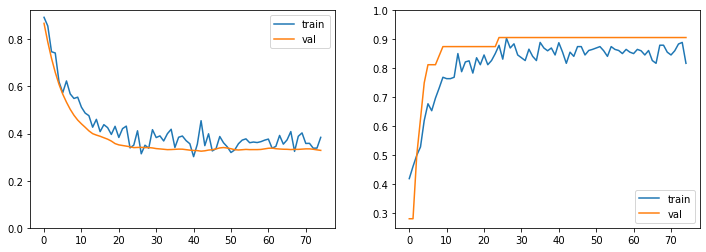

In [30]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 257ms/step - loss: 97.0850 - val_loss: 99.6150
Epoch 2/100
100/100 [==============================] - 23s 232ms/step - loss: 90.9547 - val_loss: 94.6720
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 84.1972 - val_loss: 89.7698
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 77.0072 - val_loss: 94.7817
Epoch 5/100
100/100 [==============================] - 23s 232ms/step - loss: 69.7168 - val_loss: 86.2307
Epoch 6/100
100/100 [==============================] - 23s 232ms/step - loss: 65.4740 - val_loss: 81.1838
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 57.6937 - val_loss: 84.9725
Epoch 8/100
100/100 [==============================] - 23s 232ms/step - loss: 52.7323 - val_loss: 80.0055
Epoch 9/100
100/100 [==============================] - 23s 232ms/step - loss: 47.6000 - val_loss: 89.0739
Epoch 10/100
100/100 [========================

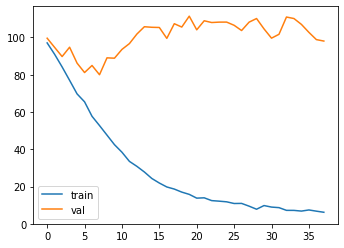

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 418ms/step - loss: 0.8206 - accuracy: 0.4286 - precision: 0.4642 - recall: 0.7016 - f1: 0.5494 - specificity: 0.1491 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: -0.1708 - equal_error_rate: 0.4880 - val_loss: 0.7469 - val_accuracy: 0.3125 - val_precision: 0.3571 - val_recall: 0.7143 - val_f1: 0.4762 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.4286 - val_equal_error_rate: 0.4722

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.42857, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_09-23_24_46.h5
Epoch 2/100
7/7 [==============================] - 1s 147ms/step - loss: 0.7763 - accuracy: 0.4856 - precision: 0.4654 - recall: 0.6754 - f1: 0.5362 - specificity: 0.3230 - negative_predictive_value: 0.5613 - matthews_correlation_coefficient: 0.0072 - equal_error_rate: 0.4787 - val_loss: 0.7171 - 


Epoch 00013: val_matthews_correlation_coefficient improved from 0.25198 to 0.30770, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_09-23_24_46.h5
Epoch 14/100
7/7 [==============================] - 1s 131ms/step - loss: 0.6158 - accuracy: 0.6442 - precision: 0.6102 - recall: 0.6106 - f1: 0.6018 - specificity: 0.6684 - negative_predictive_value: 0.6588 - matthews_correlation_coefficient: 0.2739 - equal_error_rate: 0.3429 - val_loss: 0.6389 - val_accuracy: 0.6562 - val_precision: 0.6000 - val_recall: 0.6429 - val_f1: 0.6207 - val_specificity: 0.6667 - val_negative_predictive_value: 0.7059 - val_matthews_correlation_coefficient: 0.3077 - val_equal_error_rate: 0.3452

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30770
Epoch 15/100
7/7 [==============================] - 1s 132ms/step - loss: 0.6162 - accuracy: 0.6683 - precision: 0.6826 - recall: 0.6652 - f1: 0.6676 - specificity: 0.6982 - negative_predictive_value: 0.6630 - matthews_correl

7/7 [==============================] - 1s 127ms/step - loss: 0.5715 - accuracy: 0.6971 - precision: 0.7730 - recall: 0.6570 - f1: 0.6991 - specificity: 0.7620 - negative_predictive_value: 0.6720 - matthews_correlation_coefficient: 0.4304 - equal_error_rate: 0.3030 - val_loss: 0.6404 - val_accuracy: 0.6562 - val_precision: 0.6000 - val_recall: 0.6429 - val_f1: 0.6207 - val_specificity: 0.6667 - val_negative_predictive_value: 0.7059 - val_matthews_correlation_coefficient: 0.3077 - val_equal_error_rate: 0.3452

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.30770
Epoch 28/100
7/7 [==============================] - 1s 129ms/step - loss: 0.6081 - accuracy: 0.6490 - precision: 0.6595 - recall: 0.6224 - f1: 0.6266 - specificity: 0.7045 - negative_predictive_value: 0.6497 - matthews_correlation_coefficient: 0.3179 - equal_error_rate: 0.3515 - val_loss: 0.6426 - val_accuracy: 0.6562 - val_precision: 0.6000 - val_recall: 0.6429 - val_f1: 0.6207 - val_specificity: 0.6667


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.30770
Epoch 41/100
7/7 [==============================] - 1s 131ms/step - loss: 0.6048 - accuracy: 0.6696 - precision: 0.6973 - recall: 0.6435 - f1: 0.6631 - specificity: 0.7029 - negative_predictive_value: 0.6429 - matthews_correlation_coefficient: 0.3432 - equal_error_rate: 0.3072 - val_loss: 0.6494 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 0.5714 - val_f1: 0.5714 - val_specificity: 0.6667 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2381 - val_equal_error_rate: 0.3452

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.30770
Epoch 42/100
7/7 [==============================] - 1s 129ms/step - loss: 0.5958 - accuracy: 0.6779 - precision: 0.6442 - recall: 0.6968 - f1: 0.6609 - specificity: 0.6694 - negative_predictive_value: 0.7074 - matthews_correlation_coefficient: 0.3586 - equal_error_rate: 0.3039 - val_loss: 0.6474 - val_accuracy: 0

7/7 [==============================] - 1s 128ms/step - loss: 0.5843 - accuracy: 0.6683 - precision: 0.6593 - recall: 0.6577 - f1: 0.6470 - specificity: 0.6905 - negative_predictive_value: 0.6788 - matthews_correlation_coefficient: 0.3430 - equal_error_rate: 0.3490 - val_loss: 0.6563 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 0.5714 - val_f1: 0.5714 - val_specificity: 0.6667 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2381 - val_equal_error_rate: 0.3452

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.30770
Epoch 55/100
7/7 [==============================] - 1s 130ms/step - loss: 0.5742 - accuracy: 0.6875 - precision: 0.7292 - recall: 0.6485 - f1: 0.6745 - specificity: 0.7461 - negative_predictive_value: 0.6713 - matthews_correlation_coefficient: 0.3973 - equal_error_rate: 0.3171 - val_loss: 0.6567 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 0.5714 - val_f1: 0.5714 - val_specificity: 0.6667

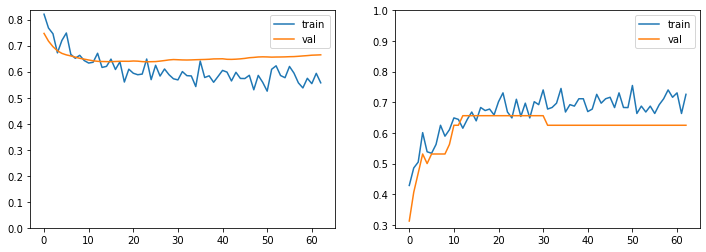

In [32]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 203ms/step - loss: 85.8040 - val_loss: 88.0709
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 55.0516 - val_loss: 86.0207
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 31.7131 - val_loss: 93.9078
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 15.8780 - val_loss: 102.7025
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 9.1651 - val_loss: 98.0181
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 7.1791 - val_loss: 93.7176
Epoch 7/100
100/100 [==============================] - 18s 179ms/step - loss: 5.3813 - val_loss: 85.8510
Epoch 8/100
100/100 [==============================] - 18s 179ms/step - loss: 4.7058 - val_loss: 96.8975
Epoch 9/100
100/100 [==============================] - 18s 179ms/step - loss: 3.8127 - val_loss: 85.0408
Epoch 10/100
100/100 [============================

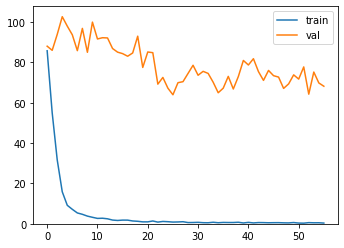

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 699ms/step - loss: 1.4696 - accuracy: 0.3672 - precision: 0.4198 - recall: 0.7471 - f1: 0.5309 - specificity: 0.0179 - negative_predictive_value: 0.0357 - matthews_correlation_coefficient: -0.3034 - equal_error_rate: 0.8049 - val_loss: 1.0527 - val_accuracy: 0.4516 - val_precision: 0.4828 - val_recall: 0.8750 - val_f1: 0.6222 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2543 - val_equal_error_rate: 0.6771

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.25427, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_09-23_44_07.h5
Epoch 2/100
4/4 [==============================] - 1s 240ms/step - loss: 1.2191 - accuracy: 0.3235 - precision: 0.4240 - recall: 0.5856 - f1: 0.4871 - specificity: 0.0000e+00 - negative_predictive_value: 0.0000e+00 - matthews_correlation_coefficient: -0.4841 - equal_error_rate: 0.6713 - 


Epoch 00013: val_matthews_correlation_coefficient improved from 0.00000 to 0.18856, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_09-23_44_07.h5
Epoch 14/100
4/4 [==============================] - 1s 148ms/step - loss: 0.6884 - accuracy: 0.6176 - precision: 0.5906 - recall: 0.5926 - f1: 0.5759 - specificity: 0.5541 - negative_predictive_value: 0.5570 - matthews_correlation_coefficient: 0.1472 - equal_error_rate: 0.4525 - val_loss: 0.6837 - val_accuracy: 0.6129 - val_precision: 0.5909 - val_recall: 0.8125 - val_f1: 0.6842 - val_specificity: 0.4000 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2340 - val_equal_error_rate: 0.4187

Epoch 00014: val_matthews_correlation_coefficient improved from 0.18856 to 0.23395, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_09-23_44_07.h5
Epoch 15/100
4/4 [==============================] - 1s 158ms/step - loss: 0.6103 - accuracy: 0.6569 - precision: 0.6

4/4 [==============================] - 1s 148ms/step - loss: 0.3561 - accuracy: 0.8824 - precision: 0.9236 - recall: 0.8928 - f1: 0.9071 - specificity: 0.9162 - negative_predictive_value: 0.8915 - matthews_correlation_coefficient: 0.8120 - equal_error_rate: 0.1242 - val_loss: 0.6307 - val_accuracy: 0.6452 - val_precision: 0.6471 - val_recall: 0.6875 - val_f1: 0.6667 - val_specificity: 0.6000 - val_negative_predictive_value: 0.6429 - val_matthews_correlation_coefficient: 0.2887 - val_equal_error_rate: 0.2896

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.28871
Epoch 28/100
4/4 [==============================] - 1s 140ms/step - loss: 0.3728 - accuracy: 0.8627 - precision: 0.9500 - recall: 0.7809 - f1: 0.8434 - specificity: 0.8750 - negative_predictive_value: 0.8471 - matthews_correlation_coefficient: 0.7209 - equal_error_rate: 0.1181 - val_loss: 0.6306 - val_accuracy: 0.6452 - val_precision: 0.6471 - val_recall: 0.6875 - val_f1: 0.6667 - val_specificity: 0.6000

4/4 [==============================] - 1s 131ms/step - loss: 0.2913 - accuracy: 0.9216 - precision: 0.9792 - recall: 0.7944 - f1: 0.8632 - specificity: 0.9853 - negative_predictive_value: 0.8083 - matthews_correlation_coefficient: 0.7835 - equal_error_rate: 0.0635 - val_loss: 0.6488 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.4208 - val_equal_error_rate: 0.2896

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 41/100
4/4 [==============================] - 1s 143ms/step - loss: 0.2941 - accuracy: 0.9219 - precision: 0.9737 - recall: 0.8697 - f1: 0.9114 - specificity: 0.9667 - negative_predictive_value: 0.8994 - matthews_correlation_coefficient: 0.8542 - equal_error_rate: 0.1025 - val_loss: 0.6509 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 54/100
4/4 [==============================] - 1s 163ms/step - loss: 0.2625 - accuracy: 0.9510 - precision: 0.9044 - recall: 0.9183 - f1: 0.9111 - specificity: 0.8452 - negative_predictive_value: 0.8618 - matthews_correlation_coefficient: 0.7648 - equal_error_rate: 0.1003 - val_loss: 0.6772 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.4208 - val_equal_error_rate: 0.2896

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 55/100
4/4 [==============================] - 1s 132ms/step - loss: 0.2129 - accuracy: 0.9118 - precision: 1.0000 - recall: 0.8558 - f1: 0.9173 - specificity: 1.0000 - negative_predictive_value: 0.8866 - matthews_correlation_coefficient: 0.8706 - equal_error_rate: 0.0792 - val_loss: 0.6785 - val_accuracy: 0

4/4 [==============================] - 1s 140ms/step - loss: 0.2491 - accuracy: 0.9314 - precision: 0.9206 - recall: 0.9408 - f1: 0.9275 - specificity: 0.8405 - negative_predictive_value: 0.9361 - matthews_correlation_coefficient: 0.8146 - equal_error_rate: 0.0771 - val_loss: 0.7052 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.4208 - val_equal_error_rate: 0.2896

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 68/100
4/4 [==============================] - 1s 134ms/step - loss: 0.1856 - accuracy: 0.9608 - precision: 0.9694 - recall: 0.9641 - f1: 0.9662 - specificity: 0.9686 - negative_predictive_value: 0.9728 - matthews_correlation_coefficient: 0.9375 - equal_error_rate: 0.0639 - val_loss: 0.7075 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 81/100
4/4 [==============================] - 1s 143ms/step - loss: 0.1972 - accuracy: 0.9453 - precision: 0.9853 - recall: 0.9075 - f1: 0.9428 - specificity: 0.9833 - negative_predictive_value: 0.9146 - matthews_correlation_coefficient: 0.8953 - equal_error_rate: 0.0712 - val_loss: 0.7352 - val_accuracy: 0.7097 - val_precision: 0.7333 - val_recall: 0.6875 - val_f1: 0.7097 - val_specificity: 0.7333 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.4208 - val_equal_error_rate: 0.2896

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.42083
Epoch 82/100
4/4 [==============================] - 1s 125ms/step - loss: 0.1778 - accuracy: 0.9608 - precision: 1.0000 - recall: 0.9361 - f1: 0.9651 - specificity: 1.0000 - negative_predictive_value: 0.9458 - matthews_correlation_coefficient: 0.9409 - equal_error_rate: 0.0769 - val_loss: 0.7366 - val_accuracy: 0

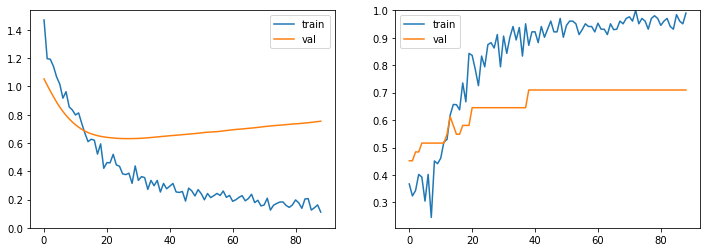

In [34]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 180ms/step - loss: 90.9703 - val_loss: 91.7902
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 65.3300 - val_loss: 72.7759
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 38.1856 - val_loss: 62.1392
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 24.0972 - val_loss: 71.5772
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 14.6250 - val_loss: 64.2874
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 7.3520 - val_loss: 61.9022
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 4.5835 - val_loss: 64.3506
Epoch 8/100
100/100 [==============================] - 16s 156ms/step - loss: 3.0648 - val_loss: 50.0347
Epoch 9/100
100/100 [==============================] - 16s 156ms/step - loss: 2.0871 - val_loss: 49.9760
Epoch 10/100
100/100 [============================

100/100 [==============================] - 16s 156ms/step - loss: 0.2207 - val_loss: 38.8759
Epoch 79/100
100/100 [==============================] - 16s 156ms/step - loss: 0.3080 - val_loss: 37.2624
Epoch 80/100
100/100 [==============================] - 16s 157ms/step - loss: 0.2263 - val_loss: 38.8086
Epoch 81/100
100/100 [==============================] - 16s 156ms/step - loss: 0.3091 - val_loss: 35.6184
Epoch 82/100
100/100 [==============================] - 16s 157ms/step - loss: 0.3108 - val_loss: 32.5366
Epoch 83/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1277 - val_loss: 30.3584
Epoch 84/100
100/100 [==============================] - 16s 156ms/step - loss: 0.2223 - val_loss: 37.7435
Epoch 85/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1936 - val_loss: 34.7975
Epoch 86/100
100/100 [==============================] - 16s 156ms/step - loss: 0.3152 - val_loss: 37.9300
Epoch 87/100
100/100 [==============================] - 16s

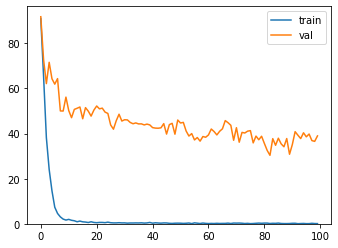

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 3s 925ms/step - loss: 1.1550 - accuracy: 0.3438 - precision: 0.4018 - recall: 0.6439 - f1: 0.4907 - specificity: 0.0442 - negative_predictive_value: 0.0833 - matthews_correlation_coefficient: -0.3941 - equal_error_rate: 0.7173 - val_loss: 0.8620 - val_accuracy: 0.4167 - val_precision: 0.4545 - val_recall: 0.8333 - val_f1: 0.5882 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.3015 - val_equal_error_rate: 0.7917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.30151, saving model to ../../models/siamese_networks/red_eyes_2020_06_10-00_12_49.h5
Epoch 2/100
3/3 [==============================] - 1s 201ms/step - loss: 1.1615 - accuracy: 0.2609 - precision: 0.3444 - recall: 0.4673 - f1: 0.3937 - specificity: 0.0434 - negative_predictive_value: 0.0833 - matthews_correlation_coefficient: -0.5284 - equal_error_rate: 0.6862 - val_loss: 0.8414 - val_a

3/3 [==============================] - 1s 183ms/step - loss: 0.5750 - accuracy: 0.6957 - precision: 0.6616 - recall: 0.8600 - f1: 0.7462 - specificity: 0.5208 - negative_predictive_value: 0.7667 - matthews_correlation_coefficient: 0.4038 - equal_error_rate: 0.2493 - val_loss: 0.6289 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.2083

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.00000
Epoch 15/100
3/3 [==============================] - 1s 175ms/step - loss: 0.6206 - accuracy: 0.6739 - precision: 0.6278 - recall: 0.7905 - f1: 0.6971 - specificity: 0.5812 - negative_predictive_value: 0.7564 - matthews_correlation_coefficient: 0.3779 - equal_error_rate: 0.2609 - val_loss: 0.6158 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specifi

3/3 [==============================] - 1s 172ms/step - loss: 0.3482 - accuracy: 0.9022 - precision: 0.8848 - recall: 0.9063 - f1: 0.8945 - specificity: 0.8946 - negative_predictive_value: 0.9125 - matthews_correlation_coefficient: 0.7992 - equal_error_rate: 0.1133 - val_loss: 0.5085 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_f1: 0.7273 - val_specificity: 0.2500 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.1250

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 28/100
3/3 [==============================] - 1s 170ms/step - loss: 0.3763 - accuracy: 0.8587 - precision: 0.8548 - recall: 0.8697 - f1: 0.8620 - specificity: 0.8331 - negative_predictive_value: 0.8545 - matthews_correlation_coefficient: 0.7060 - equal_error_rate: 0.0991 - val_loss: 0.5026 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_f1: 0.7273 - val_specificity: 0.2500


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 41/100
3/3 [==============================] - 1s 178ms/step - loss: 0.2469 - accuracy: 0.9479 - precision: 0.9370 - recall: 0.9586 - f1: 0.9463 - specificity: 0.9423 - negative_predictive_value: 0.9577 - matthews_correlation_coefficient: 0.8978 - equal_error_rate: 0.0410 - val_loss: 0.4498 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_f1: 0.7273 - val_specificity: 0.2500 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.0417

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 42/100
3/3 [==============================] - 0s 166ms/step - loss: 0.2234 - accuracy: 0.9130 - precision: 0.9188 - recall: 0.9079 - f1: 0.9118 - specificity: 0.9053 - negative_predictive_value: 0.9185 - matthews_correlation_coefficient: 0.8251 - equal_error_rate: 0.0654 - val_loss: 0.4464 - val_accuracy: 0

3/3 [==============================] - 1s 177ms/step - loss: 0.1537 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - specificity: 1.0000 - negative_predictive_value: 1.0000 - matthews_correlation_coefficient: 1.0000 - equal_error_rate: 0.0318 - val_loss: 0.4245 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_f1: 0.7273 - val_specificity: 0.2500 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.0417

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 55/100
3/3 [==============================] - 1s 169ms/step - loss: 0.1674 - accuracy: 0.9674 - precision: 0.9778 - recall: 0.9524 - f1: 0.9629 - specificity: 0.9762 - negative_predictive_value: 0.9667 - matthews_correlation_coefficient: 0.9364 - equal_error_rate: 0.0442 - val_loss: 0.4229 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_f1: 0.7273 - val_specificity: 0.2500

3/3 [==============================] - 1s 182ms/step - loss: 0.1500 - accuracy: 0.9674 - precision: 0.9569 - recall: 0.9762 - f1: 0.9654 - specificity: 0.9619 - negative_predictive_value: 0.9778 - matthews_correlation_coefficient: 0.9364 - equal_error_rate: 0.0447 - val_loss: 0.4051 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.8000 - val_specificity: 0.5000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5774 - val_equal_error_rate: 0.0417

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.57735
Epoch 68/100
3/3 [==============================] - 0s 163ms/step - loss: 0.2071 - accuracy: 0.9457 - precision: 0.9804 - recall: 0.9236 - f1: 0.9506 - specificity: 0.9744 - negative_predictive_value: 0.9111 - matthews_correlation_coefficient: 0.8947 - equal_error_rate: 0.0542 - val_loss: 0.4045 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.8000 - val_specificity: 0.5000


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.57735
Epoch 81/100
3/3 [==============================] - 1s 177ms/step - loss: 0.1661 - accuracy: 0.9688 - precision: 0.9815 - recall: 0.9649 - f1: 0.9730 - specificity: 0.9744 - negative_predictive_value: 0.9524 - matthews_correlation_coefficient: 0.9366 - equal_error_rate: 0.0534 - val_loss: 0.4048 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.8000 - val_specificity: 0.5000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5774 - val_equal_error_rate: 0.0417

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.57735
Epoch 82/100
3/3 [==============================] - 1s 186ms/step - loss: 0.1297 - accuracy: 0.9565 - precision: 0.9792 - recall: 0.9474 - f1: 0.9607 - specificity: 0.9804 - negative_predictive_value: 0.9375 - matthews_correlation_coefficient: 0.9222 - equal_error_rate: 0.0318 - val_loss: 0.4040 - val_accuracy: 0

3/3 [==============================] - 1s 188ms/step - loss: 0.0817 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1: 1.0000 - specificity: 1.0000 - negative_predictive_value: 1.0000 - matthews_correlation_coefficient: 1.0000 - equal_error_rate: 0.0318 - val_loss: 0.4003 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.8000 - val_specificity: 0.5000 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5774 - val_equal_error_rate: 0.0417

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.57735
Epoch 95/100
3/3 [==============================] - 1s 207ms/step - loss: 0.0902 - accuracy: 0.9891 - precision: 0.9778 - recall: 1.0000 - f1: 0.9885 - specificity: 0.9762 - negative_predictive_value: 1.0000 - matthews_correlation_coefficient: 0.9770 - equal_error_rate: 0.0349 - val_loss: 0.4006 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.8000 - val_specificity: 0.5000

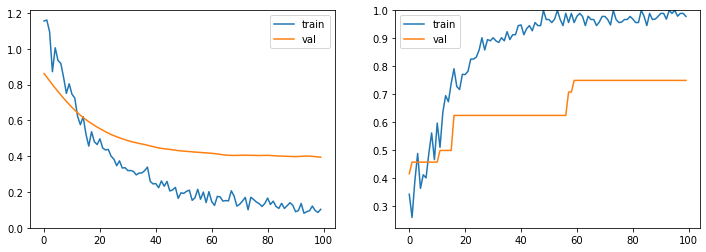

In [36]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 23s 228ms/step - loss: 81.8620 - val_loss: 77.9886
Epoch 2/100
100/100 [==============================] - 20s 200ms/step - loss: 60.3911 - val_loss: 71.7525
Epoch 3/100
100/100 [==============================] - 20s 199ms/step - loss: 43.0110 - val_loss: 60.7542
Epoch 4/100
100/100 [==============================] - 20s 200ms/step - loss: 29.5519 - val_loss: 58.9477
Epoch 5/100
100/100 [==============================] - 20s 204ms/step - loss: 20.3741 - val_loss: 60.4707
Epoch 6/100
100/100 [==============================] - 21s 208ms/step - loss: 14.5337 - val_loss: 69.1870
Epoch 7/100
100/100 [==============================] - 21s 208ms/step - loss: 11.2241 - val_loss: 55.0444
Epoch 8/100
100/100 [==============================] - 21s 208ms/step - loss: 9.8075 - val_loss: 52.6153
Epoch 9/100
100/100 [==============================] - 21s 209ms/step - loss: 7.6882 - val_loss: 40.4944
Epoch 10/100
100/100 [==========================

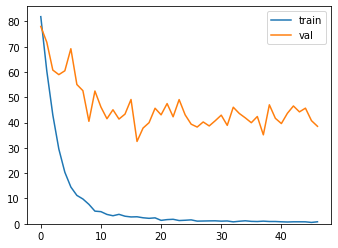

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 799ms/step - loss: 0.8889 - accuracy: 0.4297 - precision: 0.4630 - recall: 0.6796 - f1: 0.5459 - specificity: 0.1810 - negative_predictive_value: 0.3343 - matthews_correlation_coefficient: -0.1671 - equal_error_rate: 0.6253 - val_loss: 0.7707 - val_accuracy: 0.2500 - val_precision: 0.3333 - val_recall: 0.5000 - val_f1: 0.4000 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.5774 - val_equal_error_rate: 0.5938

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.57735, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_10-00_31_38.h5
Epoch 2/100
4/4 [==============================] - 1s 174ms/step - loss: 0.8002 - accuracy: 0.4921 - precision: 0.4811 - recall: 0.6191 - f1: 0.5341 - specificity: 0.3786 - negative_predictive_value: 0.5253 - matthews_correlation_coefficient: 0.0018 - equal_error_rate: 0.4972 - val_loss: 0.74

4/4 [==============================] - 1s 146ms/step - loss: 0.5362 - accuracy: 0.7302 - precision: 0.7664 - recall: 0.6381 - f1: 0.6946 - specificity: 0.8196 - negative_predictive_value: 0.7061 - matthews_correlation_coefficient: 0.4650 - equal_error_rate: 0.2856 - val_loss: 0.5382 - val_accuracy: 0.7188 - val_precision: 0.8889 - val_recall: 0.5000 - val_f1: 0.6400 - val_specificity: 0.9375 - val_negative_predictive_value: 0.6522 - val_matthews_correlation_coefficient: 0.4865 - val_equal_error_rate: 0.2812

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.48653
Epoch 14/100
4/4 [==============================] - 1s 152ms/step - loss: 0.4710 - accuracy: 0.7857 - precision: 0.8062 - recall: 0.7775 - f1: 0.7789 - specificity: 0.8122 - negative_predictive_value: 0.7922 - matthews_correlation_coefficient: 0.5939 - equal_error_rate: 0.2301 - val_loss: 0.5278 - val_accuracy: 0.7188 - val_precision: 0.8889 - val_recall: 0.5000 - val_f1: 0.6400 - val_specificity: 0.9375

4/4 [==============================] - 1s 151ms/step - loss: 0.3306 - accuracy: 0.8984 - precision: 0.9129 - recall: 0.8688 - f1: 0.8893 - specificity: 0.9225 - negative_predictive_value: 0.8871 - matthews_correlation_coefficient: 0.7956 - equal_error_rate: 0.1082 - val_loss: 0.4430 - val_accuracy: 0.8125 - val_precision: 0.9167 - val_recall: 0.6875 - val_f1: 0.7857 - val_specificity: 0.9375 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.6455 - val_equal_error_rate: 0.2188

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 27/100
4/4 [==============================] - 1s 151ms/step - loss: 0.3266 - accuracy: 0.9127 - precision: 0.9288 - recall: 0.8798 - f1: 0.9004 - specificity: 0.9367 - negative_predictive_value: 0.9054 - matthews_correlation_coefficient: 0.8251 - equal_error_rate: 0.1178 - val_loss: 0.4387 - val_accuracy: 0.8125 - val_precision: 0.9167 - val_recall: 0.6875 - val_f1: 0.7857 - val_specificity: 0.9375


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 40/100
4/4 [==============================] - 1s 140ms/step - loss: 0.2721 - accuracy: 0.9524 - precision: 0.9868 - recall: 0.9233 - f1: 0.9522 - specificity: 0.9821 - negative_predictive_value: 0.9280 - matthews_correlation_coefficient: 0.9101 - equal_error_rate: 0.0700 - val_loss: 0.4023 - val_accuracy: 0.7500 - val_precision: 0.7857 - val_recall: 0.6875 - val_f1: 0.7333 - val_specificity: 0.8125 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.5040 - val_equal_error_rate: 0.2500

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 41/100
4/4 [==============================] - 1s 159ms/step - loss: 0.2649 - accuracy: 0.9062 - precision: 0.9188 - recall: 0.8790 - f1: 0.8941 - specificity: 0.9201 - negative_predictive_value: 0.9107 - matthews_correlation_coefficient: 0.8140 - equal_error_rate: 0.0861 - val_loss: 0.4002 - val_accuracy: 0

4/4 [==============================] - 1s 156ms/step - loss: 0.2270 - accuracy: 0.9286 - precision: 0.9643 - recall: 0.8894 - f1: 0.9231 - specificity: 0.9737 - negative_predictive_value: 0.9003 - matthews_correlation_coefficient: 0.8638 - equal_error_rate: 0.0717 - val_loss: 0.3865 - val_accuracy: 0.7500 - val_precision: 0.7857 - val_recall: 0.6875 - val_f1: 0.7333 - val_specificity: 0.8125 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.5040 - val_equal_error_rate: 0.2188

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 54/100
4/4 [==============================] - 1s 145ms/step - loss: 0.2380 - accuracy: 0.9206 - precision: 0.9423 - recall: 0.8859 - f1: 0.9120 - specificity: 0.9605 - negative_predictive_value: 0.9008 - matthews_correlation_coefficient: 0.8448 - equal_error_rate: 0.0943 - val_loss: 0.3855 - val_accuracy: 0.7500 - val_precision: 0.7857 - val_recall: 0.6875 - val_f1: 0.7333 - val_specificity: 0.8125


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 67/100
4/4 [==============================] - 1s 145ms/step - loss: 0.2865 - accuracy: 0.8968 - precision: 0.9083 - recall: 0.8758 - f1: 0.8875 - specificity: 0.9011 - negative_predictive_value: 0.9041 - matthews_correlation_coefficient: 0.7943 - equal_error_rate: 0.1336 - val_loss: 0.3786 - val_accuracy: 0.7812 - val_precision: 0.8000 - val_recall: 0.7500 - val_f1: 0.7742 - val_specificity: 0.8125 - val_negative_predictive_value: 0.7647 - val_matthews_correlation_coefficient: 0.5636 - val_equal_error_rate: 0.2188

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 68/100
4/4 [==============================] - 1s 150ms/step - loss: 0.1357 - accuracy: 0.9683 - precision: 0.9821 - recall: 0.9482 - f1: 0.9646 - specificity: 0.9844 - negative_predictive_value: 0.9563 - matthews_correlation_coefficient: 0.9355 - equal_error_rate: 0.0476 - val_loss: 0.3777 - val_accuracy: 0

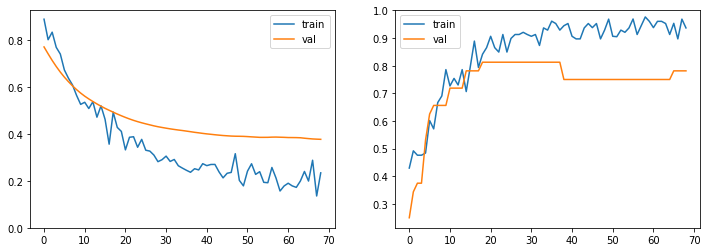

In [38]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 262ms/step - loss: 84.3592 - val_loss: 66.4735
Epoch 2/100
100/100 [==============================] - 23s 235ms/step - loss: 61.1794 - val_loss: 65.4392
Epoch 3/100
100/100 [==============================] - 23s 234ms/step - loss: 40.5620 - val_loss: 59.4443
Epoch 4/100
100/100 [==============================] - 24s 235ms/step - loss: 20.2728 - val_loss: 48.7284
Epoch 5/100
100/100 [==============================] - 23s 234ms/step - loss: 11.5114 - val_loss: 44.5909
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 8.5703 - val_loss: 37.8278
Epoch 7/100
100/100 [==============================] - 23s 234ms/step - loss: 6.1080 - val_loss: 42.1921
Epoch 8/100
100/100 [==============================] - 23s 235ms/step - loss: 4.7510 - val_loss: 41.8989
Epoch 9/100
100/100 [==============================] - 24s 235ms/step - loss: 3.6299 - val_loss: 40.7696
Epoch 10/100
100/100 [============================

100/100 [==============================] - 23s 233ms/step - loss: 0.3909 - val_loss: 27.5122
Epoch 79/100
100/100 [==============================] - 23s 233ms/step - loss: 0.6378 - val_loss: 24.6067
Epoch 80/100
100/100 [==============================] - 23s 233ms/step - loss: 0.5173 - val_loss: 23.2097
Epoch 81/100
100/100 [==============================] - 23s 233ms/step - loss: 0.5269 - val_loss: 25.7058
Epoch 82/100
100/100 [==============================] - 23s 233ms/step - loss: 0.3190 - val_loss: 29.2844
Epoch 83/100
100/100 [==============================] - 23s 233ms/step - loss: 0.4144 - val_loss: 29.8176
Epoch 84/100
100/100 [==============================] - 23s 233ms/step - loss: 0.3595 - val_loss: 25.0273
Epoch 85/100
100/100 [==============================] - 23s 233ms/step - loss: 0.3698 - val_loss: 25.2665
Epoch 86/100
100/100 [==============================] - 23s 233ms/step - loss: 0.4895 - val_loss: 27.0165
Epoch 87/100
100/100 [==============================] - 23s

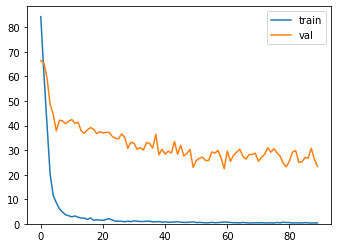

In [39]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 4s 555ms/step - loss: 0.8244 - accuracy: 0.5268 - precision: 0.5366 - recall: 0.7268 - f1: 0.6131 - specificity: 0.3164 - negative_predictive_value: 0.4946 - matthews_correlation_coefficient: 0.0380 - equal_error_rate: 0.4768 - val_loss: 0.7787 - val_accuracy: 0.4688 - val_precision: 0.4803 - val_recall: 0.8706 - val_f1: 0.6190 - val_specificity: 0.0588 - val_negative_predictive_value: 0.2000 - val_matthews_correlation_coefficient: -0.1409 - val_equal_error_rate: 0.6088

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.14095, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_10-01_09_57.h5
Epoch 2/100
7/7 [==============================] - 1s 174ms/step - loss: 0.7933 - accuracy: 0.4727 - precision: 0.4851 - recall: 0.6599 - f1: 0.5514 - specificity: 0.2848 - negative_predictive_value: 0.4534 - matthews_correlation_coefficient: -0.0582 - equal_error_rate: 0.5450 - val_loss: 0.7281 - val

7/7 [==============================] - 1s 160ms/step - loss: 0.5441 - accuracy: 0.7318 - precision: 0.7111 - recall: 0.7065 - f1: 0.7066 - specificity: 0.7288 - negative_predictive_value: 0.7267 - matthews_correlation_coefficient: 0.4365 - equal_error_rate: 0.2896 - val_loss: 0.4514 - val_accuracy: 0.7188 - val_precision: 0.6426 - val_recall: 1.0000 - val_f1: 0.7805 - val_specificity: 0.4431 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5329 - val_equal_error_rate: 0.2657

Epoch 00013: val_matthews_correlation_coefficient improved from 0.48749 to 0.53294, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_10-01_09_57.h5
Epoch 14/100
7/7 [==============================] - 1s 155ms/step - loss: 0.5337 - accuracy: 0.7636 - precision: 0.7796 - recall: 0.7109 - f1: 0.7378 - specificity: 0.7962 - negative_predictive_value: 0.7501 - matthews_correlation_coefficient: 0.5181 - equal_error_rate: 0.2816 - val_loss: 0.4395 - val_accuracy: 

7/7 [==============================] - 1s 154ms/step - loss: 0.4738 - accuracy: 0.7773 - precision: 0.8241 - recall: 0.6786 - f1: 0.7269 - specificity: 0.8287 - negative_predictive_value: 0.7514 - matthews_correlation_coefficient: 0.5382 - equal_error_rate: 0.2447 - val_loss: 0.3773 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.7992 - val_specificity: 0.5020 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5785 - val_equal_error_rate: 0.2029

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.57848
Epoch 27/100
7/7 [==============================] - 1s 159ms/step - loss: 0.4918 - accuracy: 0.8091 - precision: 0.8469 - recall: 0.7419 - f1: 0.7621 - specificity: 0.8261 - negative_predictive_value: 0.8092 - matthews_correlation_coefficient: 0.6053 - equal_error_rate: 0.2076 - val_loss: 0.3774 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_f1: 0.7992 - val_specificity: 0.5020

7/7 [==============================] - 1s 156ms/step - loss: 0.5065 - accuracy: 0.7682 - precision: 0.7863 - recall: 0.6777 - f1: 0.7052 - specificity: 0.8185 - negative_predictive_value: 0.7598 - matthews_correlation_coefficient: 0.5179 - equal_error_rate: 0.2281 - val_loss: 0.3678 - val_accuracy: 0.7656 - val_precision: 0.6803 - val_recall: 1.0000 - val_f1: 0.8094 - val_specificity: 0.5314 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.6011 - val_equal_error_rate: 0.1716

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.60112
Epoch 40/100
7/7 [==============================] - 1s 156ms/step - loss: 0.5200 - accuracy: 0.7318 - precision: 0.7413 - recall: 0.6380 - f1: 0.6627 - specificity: 0.7799 - negative_predictive_value: 0.7372 - matthews_correlation_coefficient: 0.4447 - equal_error_rate: 0.2469 - val_loss: 0.3672 - val_accuracy: 0.7656 - val_precision: 0.6803 - val_recall: 1.0000 - val_f1: 0.8094 - val_specificity: 0.5314

7/7 [==============================] - 1s 164ms/step - loss: 0.4754 - accuracy: 0.7864 - precision: 0.7628 - recall: 0.7113 - f1: 0.7105 - specificity: 0.8031 - negative_predictive_value: 0.8006 - matthews_correlation_coefficient: 0.5360 - equal_error_rate: 0.1917 - val_loss: 0.3555 - val_accuracy: 0.7812 - val_precision: 0.6951 - val_recall: 1.0000 - val_f1: 0.8200 - val_specificity: 0.5608 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.6240 - val_equal_error_rate: 0.1716

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.62397
Epoch 53/100
7/7 [==============================] - 1s 156ms/step - loss: 0.4849 - accuracy: 0.7909 - precision: 0.8480 - recall: 0.7084 - f1: 0.7448 - specificity: 0.8384 - negative_predictive_value: 0.7834 - matthews_correlation_coefficient: 0.5823 - equal_error_rate: 0.2255 - val_loss: 0.3585 - val_accuracy: 0.7812 - val_precision: 0.6951 - val_recall: 1.0000 - val_f1: 0.8200 - val_specificity: 0.5608

7/7 [==============================] - 1s 161ms/step - loss: 0.5425 - accuracy: 0.7366 - precision: 0.7658 - recall: 0.6818 - f1: 0.7095 - specificity: 0.7702 - negative_predictive_value: 0.7166 - matthews_correlation_coefficient: 0.4666 - equal_error_rate: 0.2450 - val_loss: 0.3506 - val_accuracy: 0.7969 - val_precision: 0.7105 - val_recall: 1.0000 - val_f1: 0.8304 - val_specificity: 0.5941 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.6496 - val_equal_error_rate: 0.1716

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.64962
Epoch 66/100
7/7 [==============================] - 1s 159ms/step - loss: 0.4982 - accuracy: 0.8091 - precision: 0.8763 - recall: 0.7276 - f1: 0.7812 - specificity: 0.8606 - negative_predictive_value: 0.7787 - matthews_correlation_coefficient: 0.6191 - equal_error_rate: 0.1965 - val_loss: 0.3520 - val_accuracy: 0.7969 - val_precision: 0.7105 - val_recall: 1.0000 - val_f1: 0.8304 - val_specificity: 0.5941

7/7 [==============================] - 1s 149ms/step - loss: 0.5234 - accuracy: 0.7864 - precision: 0.8698 - recall: 0.6560 - f1: 0.7231 - specificity: 0.8812 - negative_predictive_value: 0.7499 - matthews_correlation_coefficient: 0.5709 - equal_error_rate: 0.2530 - val_loss: 0.3498 - val_accuracy: 0.7969 - val_precision: 0.7208 - val_recall: 0.9706 - val_f1: 0.8269 - val_specificity: 0.6235 - val_negative_predictive_value: 0.9500 - val_matthews_correlation_coefficient: 0.6312 - val_equal_error_rate: 0.1716

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.65512
Epoch 79/100
7/7 [==============================] - 1s 164ms/step - loss: 0.4675 - accuracy: 0.8091 - precision: 0.7054 - recall: 0.7277 - f1: 0.7154 - specificity: 0.8273 - negative_predictive_value: 0.8165 - matthews_correlation_coefficient: 0.5638 - equal_error_rate: 0.2077 - val_loss: 0.3498 - val_accuracy: 0.7969 - val_precision: 0.7208 - val_recall: 0.9706 - val_f1: 0.8269 - val_specificity: 0.6235

7/7 [==============================] - 1s 166ms/step - loss: 0.4287 - accuracy: 0.8045 - precision: 0.7989 - recall: 0.7739 - f1: 0.7739 - specificity: 0.7862 - negative_predictive_value: 0.8314 - matthews_correlation_coefficient: 0.5923 - equal_error_rate: 0.1718 - val_loss: 0.3526 - val_accuracy: 0.7969 - val_precision: 0.7208 - val_recall: 0.9706 - val_f1: 0.8269 - val_specificity: 0.6235 - val_negative_predictive_value: 0.9500 - val_matthews_correlation_coefficient: 0.6312 - val_equal_error_rate: 0.1716

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.67289
Epoch 92/100
7/7 [==============================] - 1s 159ms/step - loss: 0.4708 - accuracy: 0.7864 - precision: 0.7878 - recall: 0.7008 - f1: 0.7226 - specificity: 0.8197 - negative_predictive_value: 0.7838 - matthews_correlation_coefficient: 0.5426 - equal_error_rate: 0.2219 - val_loss: 0.3511 - val_accuracy: 0.7969 - val_precision: 0.7208 - val_recall: 0.9706 - val_f1: 0.8269 - val_specificity: 0.6235

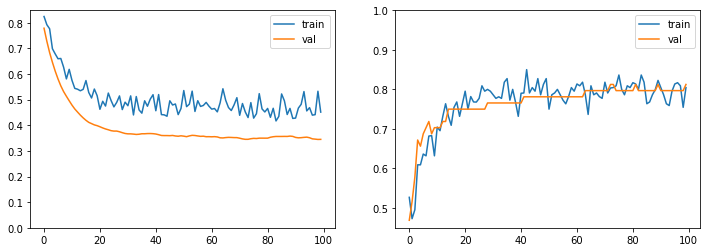

In [40]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 260ms/step - loss: 92.3416 - val_loss: 87.4632
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 81.6667 - val_loss: 94.6002
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 71.6221 - val_loss: 94.9382
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 63.8931 - val_loss: 95.8282
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 58.4151 - val_loss: 97.8603
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 50.1453 - val_loss: 96.7949
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 41.7748 - val_loss: 93.4729
Epoch 8/100
100/100 [==============================] - 23s 230ms/step - loss: 38.1821 - val_loss: 92.9463
Epoch 9/100
100/100 [==============================] - 23s 230ms/step - loss: 31.0113 - val_loss: 94.4102
Epoch 10/100
100/100 [========================

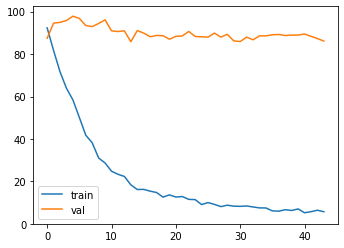

In [41]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
15/15 [==============================] - 5s 364ms/step - loss: 1.0177 - accuracy: 0.4354 - precision: 0.4691 - recall: 0.7112 - f1: 0.5549 - specificity: 0.1623 - negative_predictive_value: 0.3020 - matthews_correlation_coefficient: -0.1674 - equal_error_rate: 0.5858 - val_loss: 0.6604 - val_accuracy: 0.5833 - val_precision: 0.5899 - val_recall: 0.2739 - val_f1: 0.3689 - val_specificity: 0.8390 - val_negative_predictive_value: 0.5766 - val_matthews_correlation_coefficient: 0.1367 - val_equal_error_rate: 0.5943

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.13666, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_10-01_31_24.h5
Epoch 2/100
15/15 [==============================] - 2s 154ms/step - loss: 0.8604 - accuracy: 0.4661 - precision: 0.4783 - recall: 0.6090 - f1: 0.5215 - specificity: 0.3419 - negative_predictive_value: 0.4597 - matthews_correlation_coefficient: -0.0553 - equal_error_rate: 0.4859 - val_loss: 0.6593 - v

15/15 [==============================] - 2s 142ms/step - loss: 0.5224 - accuracy: 0.7394 - precision: 0.7842 - recall: 0.6390 - f1: 0.6928 - specificity: 0.8170 - negative_predictive_value: 0.7009 - matthews_correlation_coefficient: 0.4693 - equal_error_rate: 0.2664 - val_loss: 1.0404 - val_accuracy: 0.5000 - val_precision: 0.4753 - val_recall: 0.8320 - val_f1: 0.6028 - val_specificity: 0.2203 - val_negative_predictive_value: 0.6016 - val_matthews_correlation_coefficient: 0.0636 - val_equal_error_rate: 0.4493

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.25709
Epoch 15/100
15/15 [==============================] - 2s 143ms/step - loss: 0.5167 - accuracy: 0.7542 - precision: 0.7988 - recall: 0.6778 - f1: 0.7239 - specificity: 0.8157 - negative_predictive_value: 0.7232 - matthews_correlation_coefficient: 0.5066 - equal_error_rate: 0.2557 - val_loss: 1.0785 - val_accuracy: 0.5000 - val_precision: 0.4753 - val_recall: 0.8320 - val_f1: 0.6028 - val_specificity: 0.


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.25709
Epoch 28/100
15/15 [==============================] - 2s 149ms/step - loss: 0.5178 - accuracy: 0.7669 - precision: 0.8262 - recall: 0.6789 - f1: 0.7343 - specificity: 0.8194 - negative_predictive_value: 0.7239 - matthews_correlation_coefficient: 0.5213 - equal_error_rate: 0.2697 - val_loss: 1.3969 - val_accuracy: 0.4479 - val_precision: 0.4453 - val_recall: 0.8320 - val_f1: 0.5785 - val_specificity: 0.1212 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: -0.0642 - val_equal_error_rate: 0.4704

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.25709
Epoch 29/100
15/15 [==============================] - 2s 146ms/step - loss: 0.4545 - accuracy: 0.7881 - precision: 0.8507 - recall: 0.7001 - f1: 0.7542 - specificity: 0.8550 - negative_predictive_value: 0.7559 - matthews_correlation_coefficient: 0.5789 - equal_error_rate: 0.2254 - val_loss: 1.4192 - val_accura

15/15 [==============================] - 3s 186ms/step - loss: 0.4659 - accuracy: 0.7839 - precision: 0.8077 - recall: 0.7529 - f1: 0.7705 - specificity: 0.8117 - negative_predictive_value: 0.7759 - matthews_correlation_coefficient: 0.5735 - equal_error_rate: 0.2200 - val_loss: 1.5157 - val_accuracy: 0.4583 - val_precision: 0.4527 - val_recall: 0.8577 - val_f1: 0.5905 - val_specificity: 0.1212 - val_negative_predictive_value: 0.4944 - val_matthews_correlation_coefficient: -0.0328 - val_equal_error_rate: 0.4704

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.25709
Epoch 42/100
15/15 [==============================] - 2s 154ms/step - loss: 0.4455 - accuracy: 0.7945 - precision: 0.8188 - recall: 0.7300 - f1: 0.7638 - specificity: 0.8354 - negative_predictive_value: 0.7680 - matthews_correlation_coefficient: 0.5750 - equal_error_rate: 0.2091 - val_loss: 1.5213 - val_accuracy: 0.4583 - val_precision: 0.4527 - val_recall: 0.8577 - val_f1: 0.5905 - val_specificity: 0

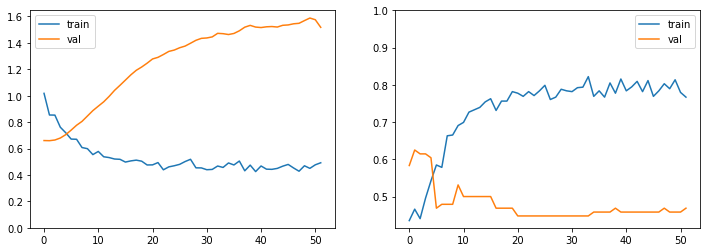

In [42]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 281ms/step - loss: 89.6941 - val_loss: 109.7766
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 72.2846 - val_loss: 130.6153
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 59.6157 - val_loss: 136.2379
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 55.8238 - val_loss: 140.0710
Epoch 5/100
100/100 [==============================] - 25s 248ms/step - loss: 50.3458 - val_loss: 143.1900
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 49.9826 - val_loss: 142.8346
Epoch 7/100
100/100 [==============================] - 25s 248ms/step - loss: 46.5783 - val_loss: 143.5858
Epoch 8/100
100/100 [==============================] - 25s 246ms/step - loss: 42.9711 - val_loss: 133.3246
Epoch 9/100
100/100 [==============================] - 25s 246ms/step - loss: 36.0102 - val_loss: 126.0146
Epoch 10/100
100/100 [===============

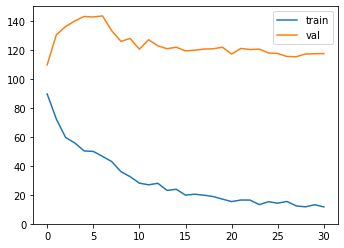

In [43]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
21/21 [==============================] - 6s 300ms/step - loss: 0.7041 - accuracy: 0.5491 - precision: 0.5388 - recall: 0.6932 - f1: 0.5997 - specificity: 0.4051 - negative_predictive_value: 0.5634 - matthews_correlation_coefficient: 0.1000 - equal_error_rate: 0.4192 - val_loss: 0.6527 - val_accuracy: 0.6125 - val_precision: 0.7006 - val_recall: 0.4655 - val_f1: 0.5443 - val_specificity: 0.7877 - val_negative_predictive_value: 0.5819 - val_matthews_correlation_coefficient: 0.2673 - val_equal_error_rate: 0.3681

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26732, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_10-01_49_21.h5
Epoch 2/100
21/21 [==============================] - 3s 151ms/step - loss: 0.6886 - accuracy: 0.5691 - precision: 0.5661 - recall: 0.6586 - f1: 0.5997 - specificity: 0.4869 - negative_predictive_value: 0.5825 - matthews_correlation_coefficient: 0.1470 - equal_error_rate: 0.4173 - val_loss: 0.64

21/21 [==============================] - 3s 148ms/step - loss: 0.6699 - accuracy: 0.6036 - precision: 0.6022 - recall: 0.6526 - f1: 0.6212 - specificity: 0.5528 - negative_predictive_value: 0.6022 - matthews_correlation_coefficient: 0.2049 - equal_error_rate: 0.3867 - val_loss: 0.6371 - val_accuracy: 0.5938 - val_precision: 0.7032 - val_recall: 0.4191 - val_f1: 0.5048 - val_specificity: 0.8031 - val_negative_predictive_value: 0.5658 - val_matthews_correlation_coefficient: 0.2440 - val_equal_error_rate: 0.3999

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.27876
Epoch 15/100
21/21 [==============================] - 3s 147ms/step - loss: 0.6742 - accuracy: 0.5946 - precision: 0.5895 - recall: 0.6295 - f1: 0.6010 - specificity: 0.5631 - negative_predictive_value: 0.6019 - matthews_correlation_coefficient: 0.1920 - equal_error_rate: 0.3789 - val_loss: 0.6358 - val_accuracy: 0.5875 - val_precision: 0.6965 - val_recall: 0.4086 - val_f1: 0.4940 - val_specificity: 0.


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.27876
Epoch 28/100
21/21 [==============================] - 3s 144ms/step - loss: 0.6554 - accuracy: 0.6306 - precision: 0.6293 - recall: 0.6262 - f1: 0.6230 - specificity: 0.6346 - negative_predictive_value: 0.6289 - matthews_correlation_coefficient: 0.2594 - equal_error_rate: 0.3734 - val_loss: 0.6254 - val_accuracy: 0.5875 - val_precision: 0.7139 - val_recall: 0.3875 - val_f1: 0.4767 - val_specificity: 0.8284 - val_negative_predictive_value: 0.5631 - val_matthews_correlation_coefficient: 0.2435 - val_equal_error_rate: 0.3867

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.27876
Epoch 29/100
21/21 [==============================] - 3s 145ms/step - loss: 0.6514 - accuracy: 0.6366 - precision: 0.6423 - recall: 0.6235 - f1: 0.6251 - specificity: 0.6541 - negative_predictive_value: 0.6371 - matthews_correlation_coefficient: 0.2784 - equal_error_rate: 0.3640 - val_loss: 0.6260 - val_accurac

21/21 [==============================] - 3s 142ms/step - loss: 0.6300 - accuracy: 0.6381 - precision: 0.6536 - recall: 0.5959 - f1: 0.6150 - specificity: 0.6837 - negative_predictive_value: 0.6292 - matthews_correlation_coefficient: 0.2811 - equal_error_rate: 0.3518 - val_loss: 0.6244 - val_accuracy: 0.5813 - val_precision: 0.7006 - val_recall: 0.3764 - val_f1: 0.4622 - val_specificity: 0.8284 - val_negative_predictive_value: 0.5597 - val_matthews_correlation_coefficient: 0.2299 - val_equal_error_rate: 0.3777

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.27876
Epoch 42/100
21/21 [==============================] - 3s 141ms/step - loss: 0.6539 - accuracy: 0.6426 - precision: 0.6659 - recall: 0.6109 - f1: 0.6271 - specificity: 0.6759 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.2904 - equal_error_rate: 0.3594 - val_loss: 0.6236 - val_accuracy: 0.5813 - val_precision: 0.7006 - val_recall: 0.3764 - val_f1: 0.4622 - val_specificity: 0.

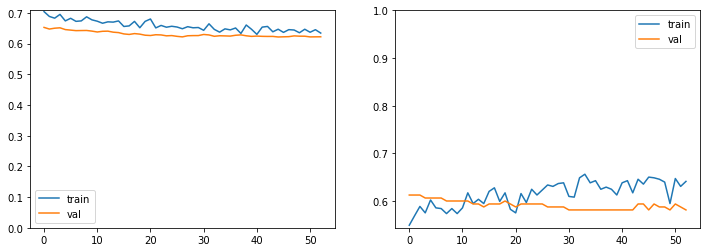

In [44]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 282ms/step - loss: 98.5147 - val_loss: 95.3776
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 87.2646 - val_loss: 81.9321
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 72.9968 - val_loss: 87.3352
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 63.9609 - val_loss: 86.9093
Epoch 5/100
100/100 [==============================] - 25s 246ms/step - loss: 56.2418 - val_loss: 93.9400
Epoch 6/100
100/100 [==============================] - 25s 246ms/step - loss: 46.8206 - val_loss: 80.9052
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 41.7261 - val_loss: 80.9112
Epoch 8/100
100/100 [==============================] - 25s 246ms/step - loss: 30.7875 - val_loss: 75.5084
Epoch 9/100
100/100 [==============================] - 25s 246ms/step - loss: 28.4097 - val_loss: 77.4715
Epoch 10/100
100/100 [========================

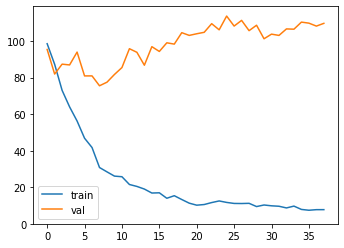

In [45]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
16/16 [==============================] - 6s 367ms/step - loss: 0.7111 - accuracy: 0.5195 - precision: 0.5374 - recall: 0.5339 - f1: 0.5176 - specificity: 0.5332 - negative_predictive_value: 0.5320 - matthews_correlation_coefficient: 0.0681 - equal_error_rate: 0.4372 - val_loss: 0.6501 - val_accuracy: 0.6250 - val_precision: 0.8661 - val_recall: 0.2946 - val_f1: 0.4361 - val_specificity: 0.9567 - val_negative_predictive_value: 0.5756 - val_matthews_correlation_coefficient: 0.3323 - val_equal_error_rate: 0.3771

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33230, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_10-02_10_54.h5
Epoch 2/100
16/16 [==============================] - 3s 158ms/step - loss: 0.6788 - accuracy: 0.5737 - precision: 0.5928 - recall: 0.5211 - f1: 0.5412 - specificity: 0.6445 - negative_predictive_value: 0.5781 - matthews_correlation_coefficient: 0.1680 - equal_error_rate: 0.4125 - val_loss: 0.6467 - va

16/16 [==============================] - 2s 135ms/step - loss: 0.6233 - accuracy: 0.6494 - precision: 0.7009 - recall: 0.5690 - f1: 0.6211 - specificity: 0.7461 - negative_predictive_value: 0.6213 - matthews_correlation_coefficient: 0.3184 - equal_error_rate: 0.3343 - val_loss: 0.6735 - val_accuracy: 0.6406 - val_precision: 0.8875 - val_recall: 0.3291 - val_f1: 0.4748 - val_specificity: 0.9567 - val_negative_predictive_value: 0.5875 - val_matthews_correlation_coefficient: 0.3677 - val_equal_error_rate: 0.4071

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39590
Epoch 15/100
16/16 [==============================] - 2s 133ms/step - loss: 0.6081 - accuracy: 0.6594 - precision: 0.6867 - recall: 0.5886 - f1: 0.6234 - specificity: 0.7431 - negative_predictive_value: 0.6497 - matthews_correlation_coefficient: 0.3339 - equal_error_rate: 0.3402 - val_loss: 0.6736 - val_accuracy: 0.6328 - val_precision: 0.8786 - val_recall: 0.3124 - val_f1: 0.4580 - val_specificity: 0.


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.39590
Epoch 28/100
16/16 [==============================] - 2s 135ms/step - loss: 0.6039 - accuracy: 0.6574 - precision: 0.6929 - recall: 0.5753 - f1: 0.6185 - specificity: 0.7549 - negative_predictive_value: 0.6429 - matthews_correlation_coefficient: 0.3328 - equal_error_rate: 0.3442 - val_loss: 0.6773 - val_accuracy: 0.6328 - val_precision: 0.8786 - val_recall: 0.3124 - val_f1: 0.4580 - val_specificity: 0.9567 - val_negative_predictive_value: 0.5813 - val_matthews_correlation_coefficient: 0.3514 - val_equal_error_rate: 0.3995

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.39590
Epoch 29/100
16/16 [==============================] - 2s 135ms/step - loss: 0.5984 - accuracy: 0.6733 - precision: 0.7248 - recall: 0.5754 - f1: 0.6300 - specificity: 0.7830 - negative_predictive_value: 0.6481 - matthews_correlation_coefficient: 0.3652 - equal_error_rate: 0.3308 - val_loss: 0.6777 - val_accurac

16/16 [==============================] - 2s 133ms/step - loss: 0.6115 - accuracy: 0.6514 - precision: 0.7072 - recall: 0.5293 - f1: 0.5951 - specificity: 0.7773 - negative_predictive_value: 0.6234 - matthews_correlation_coefficient: 0.3179 - equal_error_rate: 0.3439 - val_loss: 0.6862 - val_accuracy: 0.6250 - val_precision: 0.8661 - val_recall: 0.2946 - val_f1: 0.4361 - val_specificity: 0.9567 - val_negative_predictive_value: 0.5756 - val_matthews_correlation_coefficient: 0.3323 - val_equal_error_rate: 0.3368

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.39590
Epoch 42/100
16/16 [==============================] - 2s 140ms/step - loss: 0.6173 - accuracy: 0.6614 - precision: 0.7141 - recall: 0.5574 - f1: 0.6105 - specificity: 0.7677 - negative_predictive_value: 0.6446 - matthews_correlation_coefficient: 0.3396 - equal_error_rate: 0.3526 - val_loss: 0.6847 - val_accuracy: 0.6250 - val_precision: 0.8661 - val_recall: 0.2946 - val_f1: 0.4361 - val_specificity: 0.

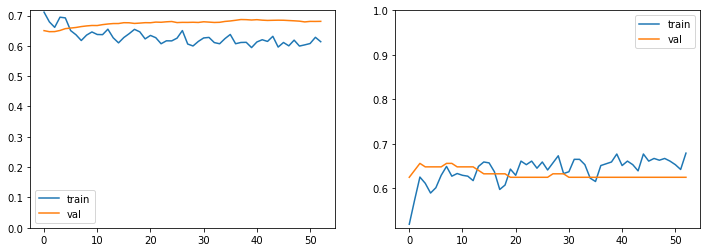

In [46]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 284ms/step - loss: 96.1227 - val_loss: 78.6436
Epoch 2/100
100/100 [==============================] - 25s 245ms/step - loss: 81.9544 - val_loss: 66.7410
Epoch 3/100
100/100 [==============================] - 24s 245ms/step - loss: 75.3056 - val_loss: 60.6687
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 70.8018 - val_loss: 57.9623
Epoch 5/100
100/100 [==============================] - 24s 245ms/step - loss: 64.1947 - val_loss: 55.4497
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 57.7075 - val_loss: 59.9653
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 47.9542 - val_loss: 62.7183
Epoch 8/100
100/100 [==============================] - 25s 245ms/step - loss: 39.0017 - val_loss: 66.7961
Epoch 9/100
100/100 [==============================] - 24s 245ms/step - loss: 32.4728 - val_loss: 70.5014
Epoch 10/100
100/100 [========================

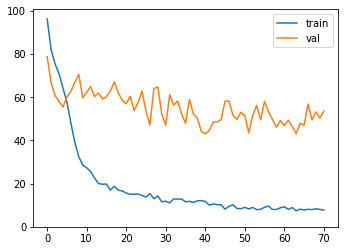

In [47]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
45/45 [==============================] - 11s 240ms/step - loss: 0.8091 - accuracy: 0.4944 - precision: 0.4956 - recall: 0.5922 - f1: 0.5303 - specificity: 0.3934 - negative_predictive_value: 0.4875 - matthews_correlation_coefficient: -0.0153 - equal_error_rate: 0.4964 - val_loss: 0.6647 - val_accuracy: 0.6420 - val_precision: 0.6789 - val_recall: 0.5500 - val_f1: 0.5953 - val_specificity: 0.7448 - val_negative_predictive_value: 0.6277 - val_matthews_correlation_coefficient: 0.3005 - val_equal_error_rate: 0.3441

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30046, saving model to ../../models/siamese_networks/hat_cap_2020_06_10-02_46_25.h5
Epoch 2/100
45/45 [==============================] - 7s 149ms/step - loss: 0.7036 - accuracy: 0.5632 - precision: 0.5534 - recall: 0.5610 - f1: 0.5514 - specificity: 0.5523 - negative_predictive_value: 0.5587 - matthews_correlation_coefficient: 0.1127 - equal_error_rate: 0.4322 - val_loss: 0.5877 - val_accuracy


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.54539
Epoch 14/100
45/45 [==============================] - 6s 136ms/step - loss: 0.5474 - accuracy: 0.7181 - precision: 0.7699 - recall: 0.6425 - f1: 0.6795 - specificity: 0.7789 - negative_predictive_value: 0.6985 - matthews_correlation_coefficient: 0.4424 - equal_error_rate: 0.2924 - val_loss: 0.5266 - val_accuracy: 0.7614 - val_precision: 0.8878 - val_recall: 0.5955 - val_f1: 0.7095 - val_specificity: 0.9233 - val_negative_predictive_value: 0.6929 - val_matthews_correlation_coefficient: 0.5480 - val_equal_error_rate: 0.2267

Epoch 00014: val_matthews_correlation_coefficient improved from 0.54539 to 0.54802, saving model to ../../models/siamese_networks/hat_cap_2020_06_10-02_46_25.h5
Epoch 15/100
45/45 [==============================] - 6s 136ms/step - loss: 0.5597 - accuracy: 0.7042 - precision: 0.7484 - recall: 0.6236 - f1: 0.6618 - specificity: 0.7700 - negative_predictive_value: 0.6845 - matthews_correlati

45/45 [==============================] - 6s 136ms/step - loss: 0.5303 - accuracy: 0.7181 - precision: 0.7686 - recall: 0.6244 - f1: 0.6755 - specificity: 0.7967 - negative_predictive_value: 0.6930 - matthews_correlation_coefficient: 0.4400 - equal_error_rate: 0.2854 - val_loss: 0.5145 - val_accuracy: 0.7443 - val_precision: 0.8800 - val_recall: 0.5668 - val_f1: 0.6854 - val_specificity: 0.9163 - val_negative_predictive_value: 0.6760 - val_matthews_correlation_coefficient: 0.5173 - val_equal_error_rate: 0.2295

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.54802
Epoch 28/100
45/45 [==============================] - 6s 134ms/step - loss: 0.5386 - accuracy: 0.7153 - precision: 0.7704 - recall: 0.6215 - f1: 0.6722 - specificity: 0.7880 - negative_predictive_value: 0.6838 - matthews_correlation_coefficient: 0.4290 - equal_error_rate: 0.2956 - val_loss: 0.5133 - val_accuracy: 0.7528 - val_precision: 0.8827 - val_recall: 0.5829 - val_f1: 0.6978 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.54802
Epoch 41/100
45/45 [==============================] - 6s 135ms/step - loss: 0.5203 - accuracy: 0.7222 - precision: 0.7667 - recall: 0.6464 - f1: 0.6877 - specificity: 0.7833 - negative_predictive_value: 0.6971 - matthews_correlation_coefficient: 0.4454 - equal_error_rate: 0.2745 - val_loss: 0.5153 - val_accuracy: 0.7415 - val_precision: 0.8784 - val_recall: 0.5584 - val_f1: 0.6796 - val_specificity: 0.9158 - val_negative_predictive_value: 0.6724 - val_matthews_correlation_coefficient: 0.5100 - val_equal_error_rate: 0.2213

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.54802
Epoch 42/100
45/45 [==============================] - 6s 134ms/step - loss: 0.5303 - accuracy: 0.7347 - precision: 0.7992 - recall: 0.6408 - f1: 0.6962 - specificity: 0.8134 - negative_predictive_value: 0.7020 - matthews_correlation_coefficient: 0.4756 - equal_error_rate: 0.2747 - val_loss: 0.5125 - val_accurac

45/45 [==============================] - 6s 134ms/step - loss: 0.5286 - accuracy: 0.7479 - precision: 0.8163 - recall: 0.6409 - f1: 0.6943 - specificity: 0.8318 - negative_predictive_value: 0.7230 - matthews_correlation_coefficient: 0.5015 - equal_error_rate: 0.2761 - val_loss: 0.5163 - val_accuracy: 0.7415 - val_precision: 0.8784 - val_recall: 0.5584 - val_f1: 0.6796 - val_specificity: 0.9158 - val_negative_predictive_value: 0.6724 - val_matthews_correlation_coefficient: 0.5100 - val_equal_error_rate: 0.2215

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.54802
Epoch 55/100
45/45 [==============================] - 6s 134ms/step - loss: 0.5216 - accuracy: 0.7375 - precision: 0.7841 - recall: 0.6583 - f1: 0.7046 - specificity: 0.8070 - negative_predictive_value: 0.7080 - matthews_correlation_coefficient: 0.4775 - equal_error_rate: 0.2554 - val_loss: 0.5148 - val_accuracy: 0.7415 - val_precision: 0.8784 - val_recall: 0.5584 - val_f1: 0.6796 - val_specificity: 0.

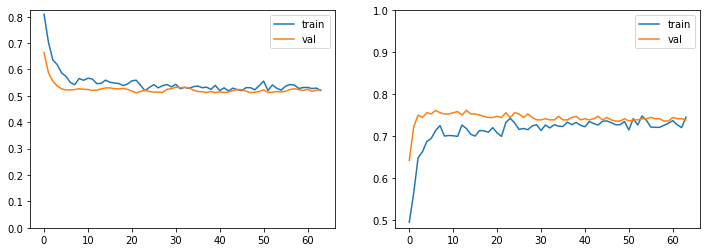

In [48]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 292ms/step - loss: 78.4270 - val_loss: 57.5206
Epoch 2/100
100/100 [==============================] - 25s 252ms/step - loss: 36.8697 - val_loss: 64.7332
Epoch 3/100
100/100 [==============================] - 25s 251ms/step - loss: 20.3082 - val_loss: 66.1260
Epoch 4/100
100/100 [==============================] - 25s 251ms/step - loss: 12.9716 - val_loss: 65.9840
Epoch 5/100
100/100 [==============================] - 25s 251ms/step - loss: 8.3883 - val_loss: 65.0445
Epoch 6/100
100/100 [==============================] - 25s 251ms/step - loss: 5.3058 - val_loss: 62.8911
Epoch 7/100
100/100 [==============================] - 25s 252ms/step - loss: 5.2034 - val_loss: 64.5261
Epoch 8/100
100/100 [==============================] - 25s 252ms/step - loss: 4.0281 - val_loss: 65.5379
Epoch 9/100
100/100 [==============================] - 25s 252ms/step - loss: 3.0346 - val_loss: 64.2021
Epoch 10/100
100/100 [=============================

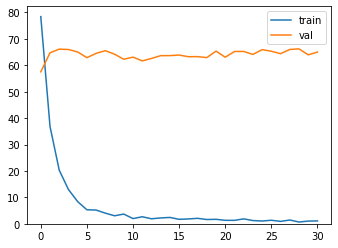

In [49]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
17/17 [==============================] - 7s 397ms/step - loss: 0.7147 - accuracy: 0.4688 - precision: 0.4740 - recall: 0.6804 - f1: 0.5565 - specificity: 0.2408 - negative_predictive_value: 0.4232 - matthews_correlation_coefficient: -0.0886 - equal_error_rate: 0.4658 - val_loss: 0.6633 - val_accuracy: 0.5859 - val_precision: 0.6518 - val_recall: 0.3754 - val_f1: 0.4697 - val_specificity: 0.8012 - val_negative_predictive_value: 0.5519 - val_matthews_correlation_coefficient: 0.1892 - val_equal_error_rate: 0.5148

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18918, saving model to ../../models/siamese_networks/veil_over_face_2020_06_10-03_09_47.h5
Epoch 2/100
17/17 [==============================] - 3s 165ms/step - loss: 0.6771 - accuracy: 0.5356 - precision: 0.5168 - recall: 0.7954 - f1: 0.6229 - specificity: 0.2821 - negative_predictive_value: 0.5915 - matthews_correlation_coefficient: 0.0910 - equal_error_rate: 0.3789 - val_loss: 0.6826 - val_ac

17/17 [==============================] - 3s 165ms/step - loss: 0.5961 - accuracy: 0.6367 - precision: 0.5915 - recall: 0.7992 - f1: 0.6777 - specificity: 0.4678 - negative_predictive_value: 0.7148 - matthews_correlation_coefficient: 0.2852 - equal_error_rate: 0.2906 - val_loss: 0.8941 - val_accuracy: 0.4531 - val_precision: 0.4793 - val_recall: 0.8051 - val_f1: 0.5970 - val_specificity: 0.0720 - val_negative_predictive_value: 0.3167 - val_matthews_correlation_coefficient: -0.1591 - val_equal_error_rate: 0.4666

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.18918
Epoch 15/100
17/17 [==============================] - 3s 164ms/step - loss: 0.5940 - accuracy: 0.6404 - precision: 0.6129 - recall: 0.7868 - f1: 0.6853 - specificity: 0.4969 - negative_predictive_value: 0.6893 - matthews_correlation_coefficient: 0.2921 - equal_error_rate: 0.3014 - val_loss: 0.9151 - val_accuracy: 0.4531 - val_precision: 0.4793 - val_recall: 0.8051 - val_f1: 0.5970 - val_specificity: 0


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.18918
Epoch 28/100
17/17 [==============================] - 3s 166ms/step - loss: 0.5657 - accuracy: 0.7079 - precision: 0.6723 - recall: 0.8028 - f1: 0.7280 - specificity: 0.6104 - negative_predictive_value: 0.7569 - matthews_correlation_coefficient: 0.4208 - equal_error_rate: 0.2562 - val_loss: 0.9279 - val_accuracy: 0.4766 - val_precision: 0.4926 - val_recall: 0.8461 - val_f1: 0.6197 - val_specificity: 0.0720 - val_negative_predictive_value: 0.3250 - val_matthews_correlation_coefficient: -0.1219 - val_equal_error_rate: 0.4201

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.18918
Epoch 29/100
17/17 [==============================] - 3s 169ms/step - loss: 0.5412 - accuracy: 0.7247 - precision: 0.6892 - recall: 0.8320 - f1: 0.7497 - specificity: 0.6167 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.4588 - equal_error_rate: 0.2464 - val_loss: 0.9248 - val_accura

17/17 [==============================] - 3s 160ms/step - loss: 0.5254 - accuracy: 0.7303 - precision: 0.7188 - recall: 0.7676 - f1: 0.7354 - specificity: 0.6928 - negative_predictive_value: 0.7526 - matthews_correlation_coefficient: 0.4657 - equal_error_rate: 0.2472 - val_loss: 0.9363 - val_accuracy: 0.4844 - val_precision: 0.4989 - val_recall: 0.8887 - val_f1: 0.6355 - val_specificity: 0.0470 - val_negative_predictive_value: 0.2917 - val_matthews_correlation_coefficient: -0.1155 - val_equal_error_rate: 0.3688

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.18918
Epoch 42/100
17/17 [==============================] - 3s 162ms/step - loss: 0.5454 - accuracy: 0.7266 - precision: 0.7051 - recall: 0.7933 - f1: 0.7409 - specificity: 0.6586 - negative_predictive_value: 0.7606 - matthews_correlation_coefficient: 0.4585 - equal_error_rate: 0.2498 - val_loss: 0.9329 - val_accuracy: 0.4766 - val_precision: 0.4945 - val_recall: 0.8740 - val_f1: 0.6281 - val_specificity: 0

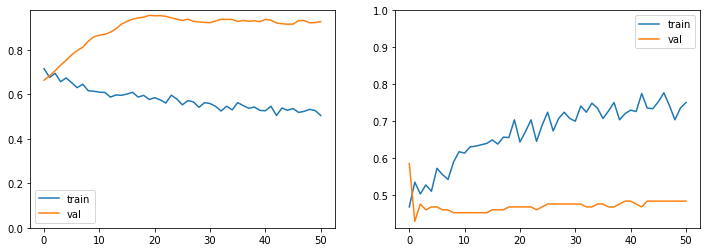

In [50]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 292ms/step - loss: 94.2231 - val_loss: 86.0742
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 79.9380 - val_loss: 101.8709
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 67.7040 - val_loss: 105.6996
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 61.0419 - val_loss: 104.5464
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 53.5561 - val_loss: 103.7029
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 45.2116 - val_loss: 104.0076
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 41.4122 - val_loss: 111.4878
Epoch 8/100
100/100 [==============================] - 25s 248ms/step - loss: 38.0740 - val_loss: 108.7315
Epoch 9/100
100/100 [==============================] - 25s 248ms/step - loss: 34.0431 - val_loss: 110.5967
Epoch 10/100
100/100 [================

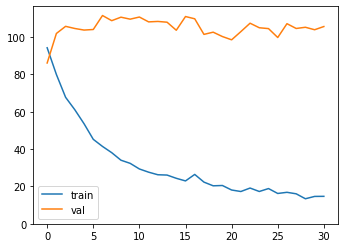

In [51]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
22/22 [==============================] - 8s 356ms/step - loss: 0.7316 - accuracy: 0.4972 - precision: 0.4960 - recall: 0.7202 - f1: 0.5831 - specificity: 0.2737 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: -0.0040 - equal_error_rate: 0.4599 - val_loss: 0.7430 - val_accuracy: 0.5437 - val_precision: 0.5209 - val_recall: 0.7258 - val_f1: 0.6035 - val_specificity: 0.3776 - val_negative_predictive_value: 0.5942 - val_matthews_correlation_coefficient: 0.1091 - val_equal_error_rate: 0.4317

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10907, saving model to ../../models/siamese_networks/mouth_open_2020_06_10-03_29_16.h5
Epoch 2/100
22/22 [==============================] - 4s 168ms/step - loss: 0.7179 - accuracy: 0.5159 - precision: 0.5079 - recall: 0.6670 - f1: 0.5692 - specificity: 0.3648 - negative_predictive_value: 0.5169 - matthews_correlation_coefficient: 0.0289 - equal_error_rate: 0.4651 - val_loss: 0.7062 - val_accura

22/22 [==============================] - 3s 151ms/step - loss: 0.6844 - accuracy: 0.5580 - precision: 0.5589 - recall: 0.5956 - f1: 0.5693 - specificity: 0.5182 - negative_predictive_value: 0.5651 - matthews_correlation_coefficient: 0.1186 - equal_error_rate: 0.4494 - val_loss: 0.6430 - val_accuracy: 0.6500 - val_precision: 0.6125 - val_recall: 0.7602 - val_f1: 0.6722 - val_specificity: 0.5489 - val_negative_predictive_value: 0.7156 - val_matthews_correlation_coefficient: 0.3182 - val_equal_error_rate: 0.3630

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.31819
Epoch 14/100
22/22 [==============================] - 3s 154ms/step - loss: 0.6611 - accuracy: 0.5855 - precision: 0.5840 - recall: 0.6380 - f1: 0.6037 - specificity: 0.5393 - negative_predictive_value: 0.5938 - matthews_correlation_coefficient: 0.1776 - equal_error_rate: 0.4010 - val_loss: 0.6444 - val_accuracy: 0.6438 - val_precision: 0.6071 - val_recall: 0.7602 - val_f1: 0.6687 - val_specificity: 0.

22/22 [==============================] - 3s 148ms/step - loss: 0.6697 - accuracy: 0.5942 - precision: 0.5990 - recall: 0.5899 - f1: 0.5902 - specificity: 0.5973 - negative_predictive_value: 0.5876 - matthews_correlation_coefficient: 0.1869 - equal_error_rate: 0.4087 - val_loss: 0.6357 - val_accuracy: 0.6562 - val_precision: 0.6248 - val_recall: 0.7602 - val_f1: 0.6780 - val_specificity: 0.5577 - val_negative_predictive_value: 0.7123 - val_matthews_correlation_coefficient: 0.3269 - val_equal_error_rate: 0.3503

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 27/100
22/22 [==============================] - 3s 151ms/step - loss: 0.6404 - accuracy: 0.6464 - precision: 0.6388 - recall: 0.6940 - f1: 0.6567 - specificity: 0.6062 - negative_predictive_value: 0.6642 - matthews_correlation_coefficient: 0.3015 - equal_error_rate: 0.3529 - val_loss: 0.6374 - val_accuracy: 0.6500 - val_precision: 0.6170 - val_recall: 0.7602 - val_f1: 0.6728 - val_specificity: 0.


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 40/100
22/22 [==============================] - 3s 147ms/step - loss: 0.6532 - accuracy: 0.6275 - precision: 0.6367 - recall: 0.6200 - f1: 0.6226 - specificity: 0.6442 - negative_predictive_value: 0.6259 - matthews_correlation_coefficient: 0.2634 - equal_error_rate: 0.3762 - val_loss: 0.6203 - val_accuracy: 0.6500 - val_precision: 0.6193 - val_recall: 0.7334 - val_f1: 0.6637 - val_specificity: 0.5708 - val_negative_predictive_value: 0.6995 - val_matthews_correlation_coefficient: 0.3111 - val_equal_error_rate: 0.3070

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 41/100
22/22 [==============================] - 3s 149ms/step - loss: 0.6488 - accuracy: 0.6174 - precision: 0.6308 - recall: 0.6069 - f1: 0.6131 - specificity: 0.6323 - negative_predictive_value: 0.6103 - matthews_correlation_coefficient: 0.2401 - equal_error_rate: 0.3841 - val_loss: 0.6230 - val_accurac

22/22 [==============================] - 4s 160ms/step - loss: 0.6413 - accuracy: 0.6275 - precision: 0.6189 - recall: 0.6341 - f1: 0.6224 - specificity: 0.6161 - negative_predictive_value: 0.6329 - matthews_correlation_coefficient: 0.2510 - equal_error_rate: 0.3815 - val_loss: 0.6238 - val_accuracy: 0.6500 - val_precision: 0.6193 - val_recall: 0.7334 - val_f1: 0.6637 - val_specificity: 0.5708 - val_negative_predictive_value: 0.6995 - val_matthews_correlation_coefficient: 0.3111 - val_equal_error_rate: 0.3070

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 54/100
22/22 [==============================] - 4s 197ms/step - loss: 0.6492 - accuracy: 0.6203 - precision: 0.6242 - recall: 0.6423 - f1: 0.6255 - specificity: 0.6022 - negative_predictive_value: 0.6224 - matthews_correlation_coefficient: 0.2455 - equal_error_rate: 0.3768 - val_loss: 0.6239 - val_accuracy: 0.6500 - val_precision: 0.6193 - val_recall: 0.7334 - val_f1: 0.6637 - val_specificity: 0.


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 67/100
22/22 [==============================] - 3s 153ms/step - loss: 0.6452 - accuracy: 0.6420 - precision: 0.6466 - recall: 0.6073 - f1: 0.6225 - specificity: 0.6630 - negative_predictive_value: 0.6276 - matthews_correlation_coefficient: 0.2722 - equal_error_rate: 0.3613 - val_loss: 0.6228 - val_accuracy: 0.6562 - val_precision: 0.6308 - val_recall: 0.6902 - val_f1: 0.6520 - val_specificity: 0.6279 - val_negative_predictive_value: 0.6950 - val_matthews_correlation_coefficient: 0.3219 - val_equal_error_rate: 0.3070

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.34147
Epoch 68/100
22/22 [==============================] - 4s 164ms/step - loss: 0.6359 - accuracy: 0.6319 - precision: 0.6302 - recall: 0.6424 - f1: 0.6293 - specificity: 0.6284 - negative_predictive_value: 0.6424 - matthews_correlation_coefficient: 0.2717 - equal_error_rate: 0.3571 - val_loss: 0.6237 - val_accurac

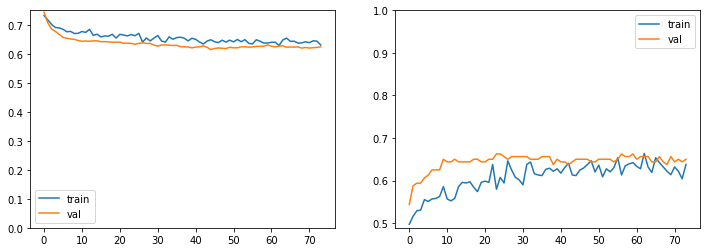

In [52]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 176ms/step - loss: 92.9236 - val_loss: 101.5644
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 73.4940 - val_loss: 126.4679
Epoch 3/100
100/100 [==============================] - 13s 127ms/step - loss: 63.5759 - val_loss: 145.2584
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 52.4203 - val_loss: 128.4644
Epoch 5/100
100/100 [==============================] - 13s 126ms/step - loss: 42.7287 - val_loss: 114.0283
Epoch 6/100
100/100 [==============================] - 13s 127ms/step - loss: 26.5456 - val_loss: 57.5462
Epoch 7/100
100/100 [==============================] - 13s 127ms/step - loss: 17.0958 - val_loss: 59.5624
Epoch 8/100
100/100 [==============================] - 13s 127ms/step - loss: 10.2585 - val_loss: 59.2065
Epoch 9/100
100/100 [==============================] - 13s 127ms/step - loss: 6.7428 - val_loss: 48.0069
Epoch 10/100
100/100 [====================

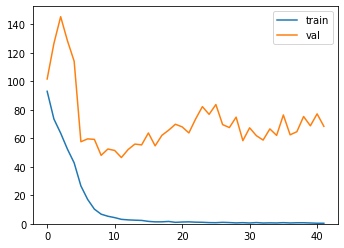

In [53]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 0.9282 - accuracy: 0.3958 - precision: 0.4218 - recall: 0.5875 - f1: 0.4762 - specificity: 0.2216 - negative_predictive_value: 0.3532 - matthews_correlation_coefficient: -0.2062 - equal_error_rate: 0.4926 - val_loss: 0.8015 - val_accuracy: 0.4118 - val_precision: 0.4545 - val_recall: 0.5556 - val_f1: 0.5000 - val_specificity: 0.2500 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.2031 - val_equal_error_rate: 0.6458

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.20309, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_10-03_46_23.h5
Epoch 2/100
3/3 [==============================] - 1s 181ms/step - loss: 0.8779 - accuracy: 0.3571 - precision: 0.3897 - recall: 0.6566 - f1: 0.4833 - specificity: 0.0794 - negative_predictive_value: 0.1944 - matthews_correlation_coefficient: -0.3307 - equal_error_rate: 0.3998 - val_loss: 0.


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 14/100
3/3 [==============================] - 0s 167ms/step - loss: 0.4787 - accuracy: 0.6714 - precision: 0.7130 - recall: 0.7256 - f1: 0.7190 - specificity: 0.7698 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.4947 - equal_error_rate: 0.2749 - val_loss: 0.7329 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.6458

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 15/100
3/3 [==============================] - 0s 157ms/step - loss: 0.7170 - accuracy: 0.6286 - precision: 0.5833 - recall: 0.5595 - f1: 0.5695 - specificity: 0.5305 - negative_predictive_value: 0.5098 - matthews_correlation_coefficient: 0.0915 - equal_error_rate: 0.5148 - val_loss: 0.7297 - val_accuracy: 0

3/3 [==============================] - 0s 152ms/step - loss: 0.4750 - accuracy: 0.7429 - precision: 0.7919 - recall: 0.6881 - f1: 0.7256 - specificity: 0.7625 - negative_predictive_value: 0.6786 - matthews_correlation_coefficient: 0.4604 - equal_error_rate: 0.1591 - val_loss: 0.6919 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.5278

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 28/100
3/3 [==============================] - 0s 164ms/step - loss: 0.4489 - accuracy: 0.8429 - precision: 0.8889 - recall: 0.7884 - f1: 0.8268 - specificity: 0.8913 - negative_predictive_value: 0.8048 - matthews_correlation_coefficient: 0.6862 - equal_error_rate: 0.1841 - val_loss: 0.6885 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 41/100
3/3 [==============================] - 0s 149ms/step - loss: 0.3900 - accuracy: 0.8854 - precision: 0.9306 - recall: 0.8558 - f1: 0.8875 - specificity: 0.9365 - negative_predictive_value: 0.8382 - matthews_correlation_coefficient: 0.7804 - equal_error_rate: 0.1354 - val_loss: 0.6765 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.1667

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 42/100
3/3 [==============================] - 1s 168ms/step - loss: 0.3513 - accuracy: 0.8429 - precision: 0.8926 - recall: 0.8653 - f1: 0.8783 - specificity: 0.8889 - negative_predictive_value: 0.8745 - matthews_correlation_coefficient: 0.7606 - equal_error_rate: 0.1514 - val_loss: 0.6755 - val_accuracy: 0

3/3 [==============================] - 0s 143ms/step - loss: 0.3376 - accuracy: 0.8429 - precision: 0.8864 - recall: 0.8215 - f1: 0.8268 - specificity: 0.8730 - negative_predictive_value: 0.8629 - matthews_correlation_coefficient: 0.7211 - equal_error_rate: 0.1302 - val_loss: 0.6568 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.5230 - val_equal_error_rate: 0.1111

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 55/100
3/3 [==============================] - 0s 150ms/step - loss: 0.2598 - accuracy: 0.9143 - precision: 1.0000 - recall: 0.8918 - f1: 0.9411 - specificity: 1.0000 - negative_predictive_value: 0.8787 - matthews_correlation_coefficient: 0.8852 - equal_error_rate: 0.0952 - val_loss: 0.6562 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 68/100
3/3 [==============================] - 0s 155ms/step - loss: 0.2408 - accuracy: 0.9286 - precision: 0.9269 - recall: 0.9522 - f1: 0.9390 - specificity: 0.9426 - negative_predictive_value: 0.9577 - matthews_correlation_coefficient: 0.8896 - equal_error_rate: 0.1090 - val_loss: 0.6535 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.5230 - val_equal_error_rate: 0.1111

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 69/100
3/3 [==============================] - 0s 156ms/step - loss: 0.3199 - accuracy: 0.8646 - precision: 0.8693 - recall: 0.8733 - f1: 0.8644 - specificity: 0.8773 - negative_predictive_value: 0.8501 - matthews_correlation_coefficient: 0.7347 - equal_error_rate: 0.1187 - val_loss: 0.6526 - val_accuracy: 0

3/3 [==============================] - 0s 158ms/step - loss: 0.2118 - accuracy: 0.9479 - precision: 0.9722 - recall: 0.9288 - f1: 0.9474 - specificity: 0.9841 - negative_predictive_value: 0.9153 - matthews_correlation_coefficient: 0.9001 - equal_error_rate: 0.0332 - val_loss: 0.6327 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.5230 - val_equal_error_rate: 0.1736

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 82/100
3/3 [==============================] - 0s 149ms/step - loss: 0.1991 - accuracy: 0.9571 - precision: 0.9804 - recall: 0.9630 - f1: 0.9714 - specificity: 0.9762 - negative_predictive_value: 0.9556 - matthews_correlation_coefficient: 0.9375 - equal_error_rate: 0.1011 - val_loss: 0.6310 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 95/100
3/3 [==============================] - 0s 164ms/step - loss: 0.2272 - accuracy: 0.9143 - precision: 0.9825 - recall: 0.9084 - f1: 0.9408 - specificity: 0.9744 - negative_predictive_value: 0.9003 - matthews_correlation_coefficient: 0.8827 - equal_error_rate: 0.1375 - val_loss: 0.6379 - val_accuracy: 0.7059 - val_precision: 1.0000 - val_recall: 0.4444 - val_f1: 0.6154 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.5230 - val_equal_error_rate: 0.1736

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.52298
Epoch 96/100
3/3 [==============================] - 0s 161ms/step - loss: 0.2317 - accuracy: 0.9286 - precision: 0.8816 - recall: 0.9649 - f1: 0.9173 - specificity: 0.8376 - negative_predictive_value: 0.9487 - matthews_correlation_coefficient: 0.8160 - equal_error_rate: 0.1227 - val_loss: 0.6387 - val_accuracy: 0

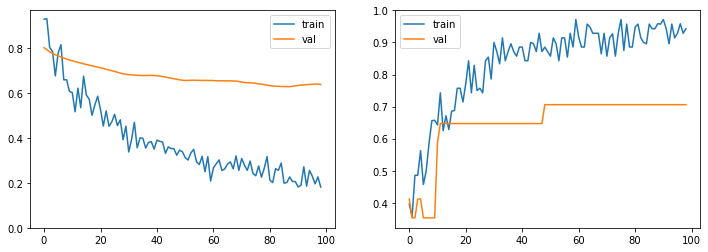

In [54]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

In [55]:
print(len(list_model_files))
print(np.array(list_model_files))

21
['../../models/siamese_networks/blurred_2020_06_09-20_52_01.h5'
 '../../models/siamese_networks/looking_away_2020_06_09-21_08_02.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_09-21_17_59.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_09-21_44_19.h5'
 '../../models/siamese_networks/washed_out_2020_06_09-22_07_44.h5'
 '../../models/siamese_networks/pixelation_2020_06_09-22_21_21.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_09-22_35_35.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_09-22_47_58.h5'
 '../../models/siamese_networks/varied_background_2020_06_09-23_07_10.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_09-23_24_46.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_09-23_44_07.h5'
 '../../models/siamese_networks/red_eyes_2020_06_10-00_12_49.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_10-00_31_38.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_10-01_09_57.h5'

# Models Merge

In [56]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [57]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [58]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [59]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_10-04_11_58.h5
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_________________________

In [60]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.2454845]], dtype=float32),
 array([[0.7211503]], dtype=float32),
 array([[0.73757946]], dtype=float32),
 array([[0.8422996]], dtype=float32),
 array([[0.2837327]], dtype=float32),
 array([[0.6754659]], dtype=float32),
 array([[0.38537347]], dtype=float32),
 array([[0.7577866]], dtype=float32),
 array([[0.94708776]], dtype=float32),
 array([[0.6262564]], dtype=float32),
 array([[0.84874505]], dtype=float32),
 array([[0.83571935]], dtype=float32),
 array([[0.21040638]], dtype=float32),
 array([[0.8992257]], dtype=float32),
 array([[0.5942217]], dtype=float32),
 array([[0.42595553]], dtype=float32),
 array([[0.69132215]], dtype=float32),
 array([[0.98671734]], dtype=float32),
 array([[0.58535814]], dtype=float32),
 array([[0.49538043]], dtype=float32),
 array([[0.70215267]], dtype=float32)]